In [1]:
import os, math
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization 
from tensorflow.keras.layers import Conv2D, Flatten, Activation
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mse, SparseCategoricalCrossentropy


In [2]:
tf.random.set_seed(42)


In [3]:
(x_train, y_train),(x_test, _) = mnist.load_data()


In [4]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 255

In [5]:
x_train.max()

1.0

In [6]:
image_size = x_train[0].shape[1]
image_size

28

In [7]:
class ConvTransBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super().__init__()
        self.bn = BatchNormalization()  # check training flag
        self.act = Activation(activation='relu')
        self.conv2D_trans = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='same')
        
    def call(self, inputs, training=False):
        x = self.bn(inputs)
        x = self.act(x)
        return self.conv2D_trans(x)


In [8]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size, resize_img):
        super().__init__()
        self.dense1 = Dense(resize_img * resize_img * filters[0])
        self.reshape = Reshape([resize_img, resize_img, filters[0]])
        self.conv2dtrans = []
        for i, _filter in enumerate(filters):
            if i <= 1:
                strides = 2
            else:
                strides = 1
            self.conv2dtrans.append(ConvTransBlock(_filter, kernel_size, strides))
        
        self.act = Activation("sigmoid")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.reshape(x)
        for conv in self.conv2dtrans:
            x = conv(x)
        return self.act(x)




In [9]:
def leaky_conv(filters, kernel_size, strides):
    return Sequential([LeakyReLU(alpha=0.2),
                       Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same')])


In [10]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.leaky_convs = []
        for i, _filter in enumerate(filters):
            if i < len(filters) - 1:
                strides = 2
            else:
                strides = 1
            self.leaky_convs.append(leaky_conv(_filter, kernel_size, strides))
        self.flat = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        for conv in self.leaky_convs:
            x = conv(x)
        x = self.flat(x)
        return self.dense(x)

In [11]:
# latent_size = 2??
# simple disc
# delete activation as input in disc


latent_size = 2
batch_size = 64
train_steps = 40000
disc_lr = 2e-4
disc_decay = 6e-8
gen_lr = disc_lr/4
gen_decay = disc_decay/4

disc_lr, disc_decay, gen_lr, gen_decay

(0.0002, 6e-08, 5e-05, 1.5e-08)

In [12]:
disc_kernel_size = 5
disc_layers_filters = [32, 64, 128]

In [13]:
gen_resize_img = image_size // 4
gen_kernel_size = 5
gen_layers_filter = [128, 64, 32, 1]

In [14]:
gen = Generator(gen_layers_filter, gen_kernel_size, gen_resize_img)

In [15]:
disc = Discriminator(disc_layers_filters, disc_kernel_size)
disc.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=disc_lr, decay=disc_decay),
             metrics=['accuracy'])


In [16]:
def build_gan():
    # disc.trainable = False
    gan = Sequential(name='gan_model')
    gan.add(Input([latent_size,]))
    gan.add(gen)
    gan.add(disc)
    gan.summary()
    gan.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=gen_lr, decay=gen_decay),
                metrics=['accuracy'])            
    return gan   


gan = build_gan()


Model: "gan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Generator)        (None, 28, 28, 1)         686849    
_________________________________________________________________
discriminator (Discriminator (None, 1)                 263297    
Total params: 950,146
Trainable params: 949,442
Non-trainable params: 704
_________________________________________________________________


In [17]:
for layer in gan.layers:
    print(layer.trainable)

True
True


In [18]:
def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    # os.makedirs(model_name, exist_ok=True)
    # filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    # plt.savefig(filename)
    if show:
        
        plt.show()
    else:
        plt.close('all')

In [19]:
# Train the Discriminator and Adversarial Networks
def train(models, x_train):
    generator, discriminator, gan = models 
    # batch_size, latent_size, train_step, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size]) 
    train_size = x_train.shape[0]

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)        
        x = np.concatenate((real_images, fake_images)) # same size
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        # experimental
        y[: batch_size] = 0.9
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch(x, y)
        # log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        log = f'{i}: [discriminator loss: {loss}, acc: {acc}]'
        discriminator.trainable = False

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])        
        loss, acc = gan.train_on_batch(noise, y)
        log = "%s [gan loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=True,
                        step=(i + 1),
                        model_name='gan_model')
    

In [20]:
print(x_train.shape, x_train.min(), x_train.max())
        

(60000, 28, 28, 1) 0.0 1.0


0: [discriminator loss: 0.6847271919250488, acc: 0.5] [gan loss: 0.915446, acc: 0.000000]
1: [discriminator loss: 0.6175202131271362, acc: 0.5] [gan loss: 0.949159, acc: 0.000000]
2: [discriminator loss: 0.5633471012115479, acc: 0.5] [gan loss: 0.981366, acc: 0.000000]
3: [discriminator loss: 0.5039212107658386, acc: 0.5] [gan loss: 0.983081, acc: 0.000000]
4: [discriminator loss: 0.4434990882873535, acc: 0.5] [gan loss: 0.967436, acc: 0.000000]
5: [discriminator loss: 0.3951553702354431, acc: 0.5] [gan loss: 0.855738, acc: 0.000000]
6: [discriminator loss: 0.3375740349292755, acc: 0.5] [gan loss: 0.751079, acc: 0.328125]
7: [discriminator loss: 0.29136592149734497, acc: 0.5] [gan loss: 0.628491, acc: 0.796875]
8: [discriminator loss: 0.2557666599750519, acc: 0.5] [gan loss: 0.464031, acc: 0.921875]
9: [discriminator loss: 0.22653530538082123, acc: 0.5] [gan loss: 0.503544, acc: 0.937500]
10: [discriminator loss: 0.21488791704177856, acc: 0.5] [gan loss: 0.179042, acc: 1.000000]
11: [d

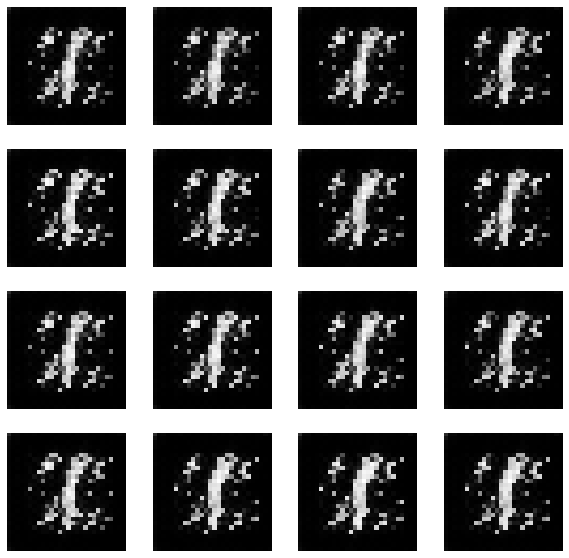

500: [discriminator loss: 0.24032457172870636, acc: 0.5] [gan loss: 0.881735, acc: 0.000000]
501: [discriminator loss: 0.23119273781776428, acc: 0.5] [gan loss: 0.721073, acc: 0.437500]
502: [discriminator loss: 0.24917294085025787, acc: 0.5] [gan loss: 0.660696, acc: 0.718750]
503: [discriminator loss: 0.24219690263271332, acc: 0.5] [gan loss: 0.663436, acc: 0.703125]
504: [discriminator loss: 0.26951324939727783, acc: 0.5] [gan loss: 0.373118, acc: 1.000000]
505: [discriminator loss: 0.26899728178977966, acc: 0.5] [gan loss: 1.267969, acc: 0.000000]
506: [discriminator loss: 0.27125680446624756, acc: 0.5] [gan loss: 0.120479, acc: 1.000000]
507: [discriminator loss: 0.3649403154850006, acc: 0.5] [gan loss: 2.119266, acc: 0.000000]
508: [discriminator loss: 0.3199409544467926, acc: 0.5] [gan loss: 0.073321, acc: 1.000000]
509: [discriminator loss: 0.4833826422691345, acc: 0.4375] [gan loss: 2.223144, acc: 0.000000]
510: [discriminator loss: 0.31120967864990234, acc: 0.5] [gan loss: 0.

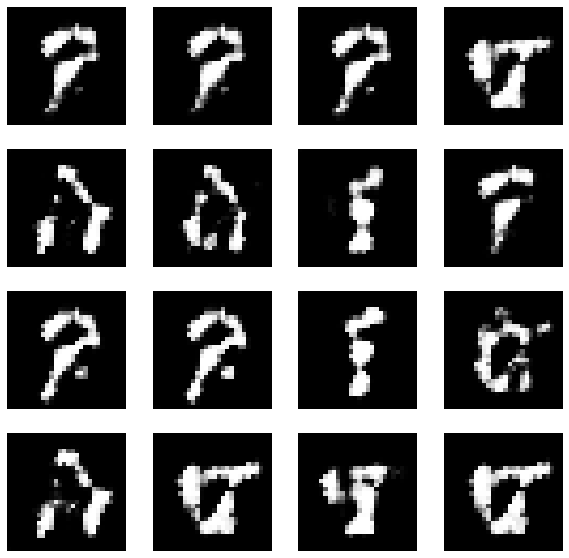

1000: [discriminator loss: 0.6551141738891602, acc: 0.5] [gan loss: 0.767647, acc: 0.140625]
1001: [discriminator loss: 0.6905713081359863, acc: 0.1484375] [gan loss: 1.000944, acc: 0.000000]
1002: [discriminator loss: 0.661568284034729, acc: 0.5] [gan loss: 0.757692, acc: 0.234375]
1003: [discriminator loss: 0.6710330843925476, acc: 0.1796875] [gan loss: 1.102348, acc: 0.000000]
1004: [discriminator loss: 0.6536530256271362, acc: 0.5] [gan loss: 0.804750, acc: 0.187500]
1005: [discriminator loss: 0.6664116382598877, acc: 0.265625] [gan loss: 1.030033, acc: 0.000000]
1006: [discriminator loss: 0.6467057466506958, acc: 0.5] [gan loss: 0.856346, acc: 0.015625]
1007: [discriminator loss: 0.6482958793640137, acc: 0.3359375] [gan loss: 1.022006, acc: 0.000000]
1008: [discriminator loss: 0.6494247913360596, acc: 0.4921875] [gan loss: 0.813115, acc: 0.187500]
1009: [discriminator loss: 0.6601155996322632, acc: 0.203125] [gan loss: 1.149664, acc: 0.000000]
1010: [discriminator loss: 0.64474362

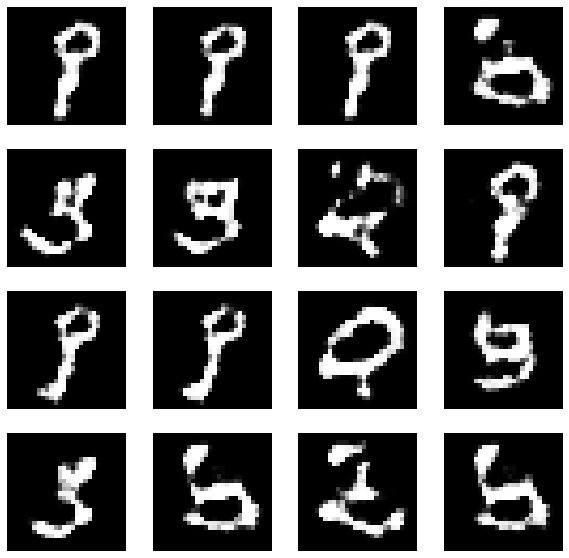

1500: [discriminator loss: 0.6781982183456421, acc: 0.453125] [gan loss: 0.808398, acc: 0.031250]
1501: [discriminator loss: 0.6986411809921265, acc: 0.265625] [gan loss: 0.919057, acc: 0.000000]
1502: [discriminator loss: 0.654593288898468, acc: 0.46875] [gan loss: 0.828920, acc: 0.093750]
1503: [discriminator loss: 0.6600798964500427, acc: 0.3359375] [gan loss: 0.923977, acc: 0.046875]
1504: [discriminator loss: 0.6860666275024414, acc: 0.40625] [gan loss: 0.892821, acc: 0.046875]
1505: [discriminator loss: 0.6790424585342407, acc: 0.390625] [gan loss: 0.890332, acc: 0.000000]
1506: [discriminator loss: 0.6671947240829468, acc: 0.4140625] [gan loss: 0.896493, acc: 0.000000]
1507: [discriminator loss: 0.672837495803833, acc: 0.328125] [gan loss: 1.027857, acc: 0.000000]
1508: [discriminator loss: 0.6524665951728821, acc: 0.4921875] [gan loss: 0.751671, acc: 0.359375]
1509: [discriminator loss: 0.6521056890487671, acc: 0.21875] [gan loss: 1.099082, acc: 0.000000]
1510: [discriminator l

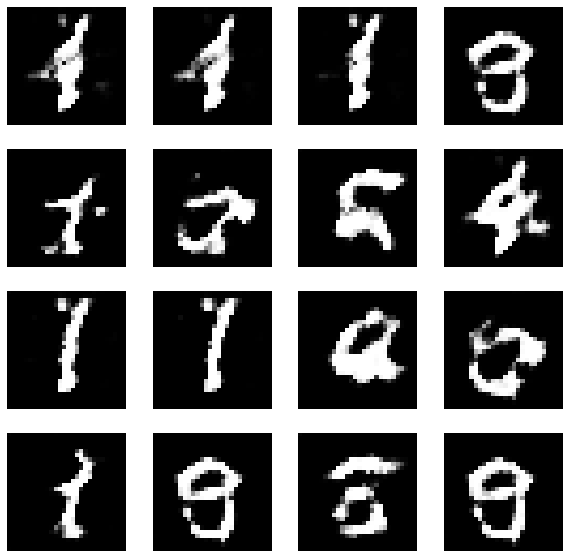

2000: [discriminator loss: 0.6705361604690552, acc: 0.4140625] [gan loss: 1.063148, acc: 0.000000]
2001: [discriminator loss: 0.6584287881851196, acc: 0.5] [gan loss: 0.812262, acc: 0.171875]
2002: [discriminator loss: 0.6607968807220459, acc: 0.3203125] [gan loss: 1.177374, acc: 0.000000]
2003: [discriminator loss: 0.6899846196174622, acc: 0.5] [gan loss: 0.803242, acc: 0.093750]
2004: [discriminator loss: 0.6750993132591248, acc: 0.2109375] [gan loss: 1.092101, acc: 0.000000]
2005: [discriminator loss: 0.6531004309654236, acc: 0.5] [gan loss: 0.766121, acc: 0.375000]
2006: [discriminator loss: 0.6634215116500854, acc: 0.25] [gan loss: 1.154366, acc: 0.000000]
2007: [discriminator loss: 0.6969433426856995, acc: 0.4609375] [gan loss: 0.820776, acc: 0.296875]
2008: [discriminator loss: 0.6751786470413208, acc: 0.296875] [gan loss: 1.006018, acc: 0.015625]
2009: [discriminator loss: 0.6863799095153809, acc: 0.3828125] [gan loss: 0.817978, acc: 0.250000]
2010: [discriminator loss: 0.69656

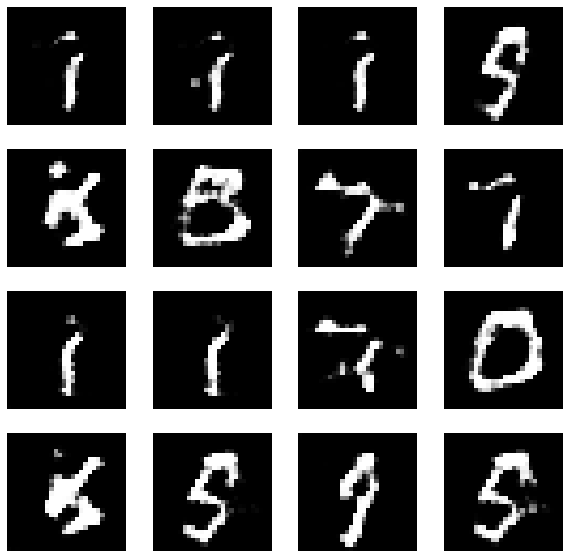

2500: [discriminator loss: 0.6735818982124329, acc: 0.453125] [gan loss: 0.815972, acc: 0.250000]
2501: [discriminator loss: 0.6868866682052612, acc: 0.171875] [gan loss: 1.112577, acc: 0.015625]
2502: [discriminator loss: 0.6474534273147583, acc: 0.484375] [gan loss: 0.827829, acc: 0.203125]
2503: [discriminator loss: 0.6348170638084412, acc: 0.3046875] [gan loss: 1.064852, acc: 0.031250]
2504: [discriminator loss: 0.6495582461357117, acc: 0.375] [gan loss: 0.960047, acc: 0.062500]
2505: [discriminator loss: 0.6395548582077026, acc: 0.3671875] [gan loss: 0.944594, acc: 0.125000]
2506: [discriminator loss: 0.6508477330207825, acc: 0.3203125] [gan loss: 1.033395, acc: 0.015625]
2507: [discriminator loss: 0.6316126585006714, acc: 0.3984375] [gan loss: 0.967566, acc: 0.156250]
2508: [discriminator loss: 0.6528486013412476, acc: 0.34375] [gan loss: 1.120823, acc: 0.000000]
2509: [discriminator loss: 0.6457740068435669, acc: 0.421875] [gan loss: 0.934507, acc: 0.078125]
2510: [discriminator

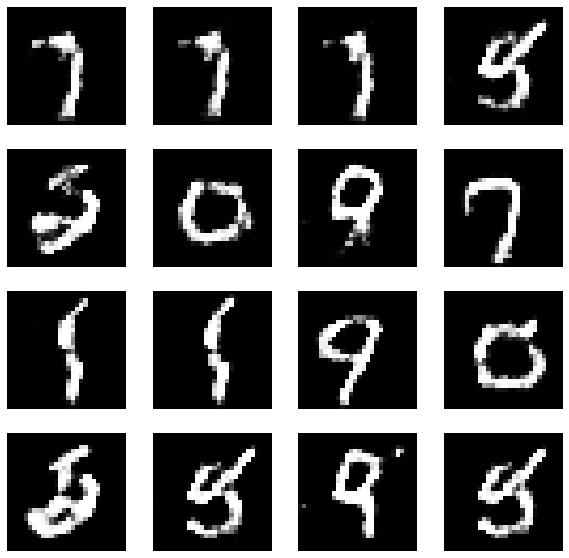

3000: [discriminator loss: 0.6966866850852966, acc: 0.2109375] [gan loss: 1.122442, acc: 0.000000]
3001: [discriminator loss: 0.6644238233566284, acc: 0.4765625] [gan loss: 0.814816, acc: 0.203125]
3002: [discriminator loss: 0.6718621850013733, acc: 0.1953125] [gan loss: 1.051911, acc: 0.000000]
3003: [discriminator loss: 0.6592604517936707, acc: 0.46875] [gan loss: 0.782997, acc: 0.187500]
3004: [discriminator loss: 0.6670427322387695, acc: 0.1484375] [gan loss: 1.127633, acc: 0.000000]
3005: [discriminator loss: 0.6488386988639832, acc: 0.5] [gan loss: 0.721363, acc: 0.437500]
3006: [discriminator loss: 0.7098426222801208, acc: 0.0859375] [gan loss: 1.270204, acc: 0.000000]
3007: [discriminator loss: 0.6853751540184021, acc: 0.4921875] [gan loss: 0.615749, acc: 0.812500]
3008: [discriminator loss: 0.7291454076766968, acc: 0.0703125] [gan loss: 1.230358, acc: 0.000000]
3009: [discriminator loss: 0.6683445572853088, acc: 0.46875] [gan loss: 0.813064, acc: 0.156250]
3010: [discriminator

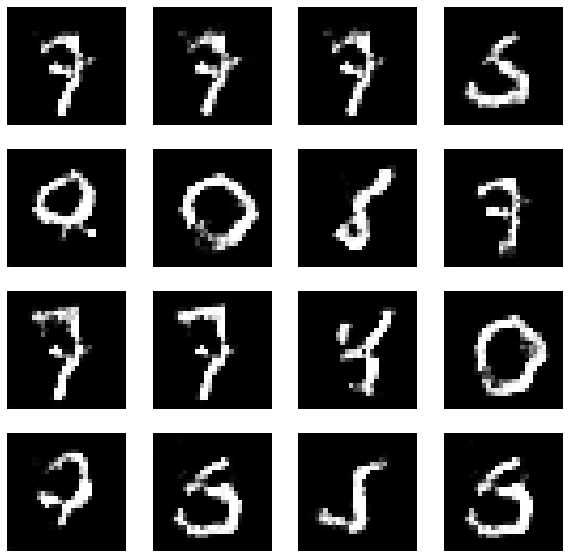

3500: [discriminator loss: 0.6339321136474609, acc: 0.4921875] [gan loss: 0.769761, acc: 0.281250]
3501: [discriminator loss: 0.6387505531311035, acc: 0.3125] [gan loss: 1.139911, acc: 0.000000]
3502: [discriminator loss: 0.6660642623901367, acc: 0.5] [gan loss: 0.734820, acc: 0.265625]
3503: [discriminator loss: 0.6396716833114624, acc: 0.265625] [gan loss: 1.126558, acc: 0.000000]
3504: [discriminator loss: 0.6278644800186157, acc: 0.484375] [gan loss: 0.804350, acc: 0.218750]
3505: [discriminator loss: 0.6374297738075256, acc: 0.3046875] [gan loss: 1.110688, acc: 0.015625]
3506: [discriminator loss: 0.6378891468048096, acc: 0.46875] [gan loss: 0.808314, acc: 0.218750]
3507: [discriminator loss: 0.6376686096191406, acc: 0.2890625] [gan loss: 1.130930, acc: 0.000000]
3508: [discriminator loss: 0.6508046984672546, acc: 0.484375] [gan loss: 0.758745, acc: 0.171875]
3509: [discriminator loss: 0.6457908153533936, acc: 0.171875] [gan loss: 1.093054, acc: 0.000000]
3510: [discriminator loss

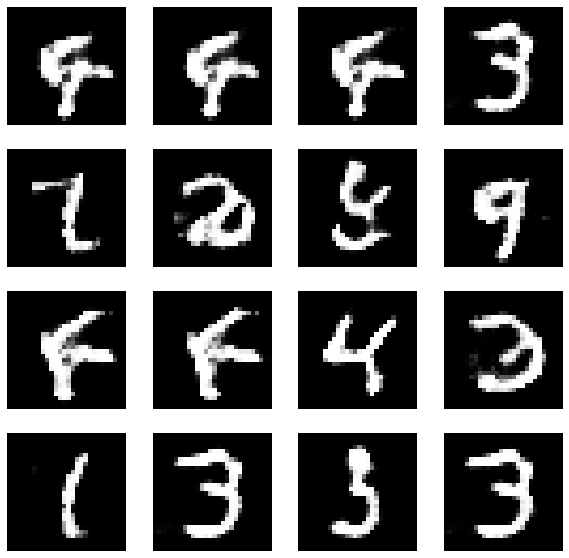

4000: [discriminator loss: 0.7656340599060059, acc: 0.0859375] [gan loss: 1.104171, acc: 0.000000]
4001: [discriminator loss: 0.7181517481803894, acc: 0.4765625] [gan loss: 0.843934, acc: 0.078125]
4002: [discriminator loss: 0.7133166790008545, acc: 0.3046875] [gan loss: 0.874195, acc: 0.015625]
4003: [discriminator loss: 0.7168283462524414, acc: 0.234375] [gan loss: 0.999878, acc: 0.000000]
4004: [discriminator loss: 0.7096922397613525, acc: 0.4765625] [gan loss: 0.828858, acc: 0.062500]
4005: [discriminator loss: 0.6951868534088135, acc: 0.28125] [gan loss: 0.984716, acc: 0.046875]
4006: [discriminator loss: 0.6880210638046265, acc: 0.4375] [gan loss: 0.937283, acc: 0.078125]
4007: [discriminator loss: 0.7120943665504456, acc: 0.3984375] [gan loss: 0.866247, acc: 0.078125]
4008: [discriminator loss: 0.6893755793571472, acc: 0.34375] [gan loss: 1.144596, acc: 0.000000]
4009: [discriminator loss: 0.678900957107544, acc: 0.4375] [gan loss: 0.889768, acc: 0.093750]
4010: [discriminator l

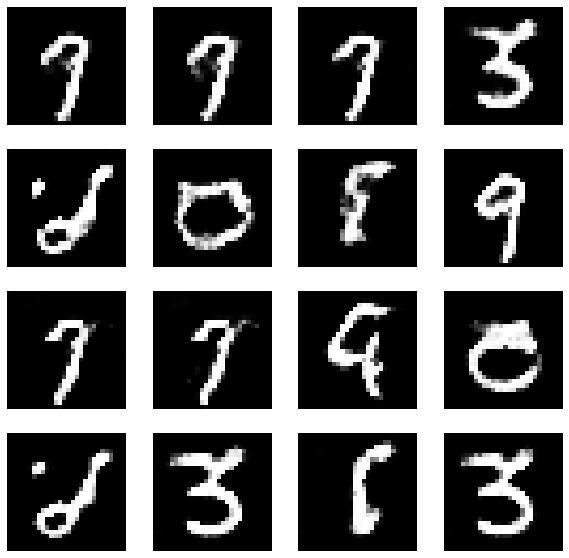

4500: [discriminator loss: 0.7011467218399048, acc: 0.4609375] [gan loss: 0.829821, acc: 0.203125]
4501: [discriminator loss: 0.6742534637451172, acc: 0.265625] [gan loss: 1.001450, acc: 0.015625]
4502: [discriminator loss: 0.6942583918571472, acc: 0.40625] [gan loss: 0.910070, acc: 0.062500]
4503: [discriminator loss: 0.659625768661499, acc: 0.40625] [gan loss: 1.027328, acc: 0.046875]
4504: [discriminator loss: 0.6633893251419067, acc: 0.40625] [gan loss: 0.901583, acc: 0.125000]
4505: [discriminator loss: 0.660345196723938, acc: 0.34375] [gan loss: 1.026535, acc: 0.000000]
4506: [discriminator loss: 0.6454356908798218, acc: 0.453125] [gan loss: 0.889555, acc: 0.046875]
4507: [discriminator loss: 0.6699636578559875, acc: 0.34375] [gan loss: 0.984514, acc: 0.015625]
4508: [discriminator loss: 0.6625993251800537, acc: 0.3984375] [gan loss: 0.849678, acc: 0.250000]
4509: [discriminator loss: 0.6516979932785034, acc: 0.2890625] [gan loss: 1.190455, acc: 0.000000]
4510: [discriminator los

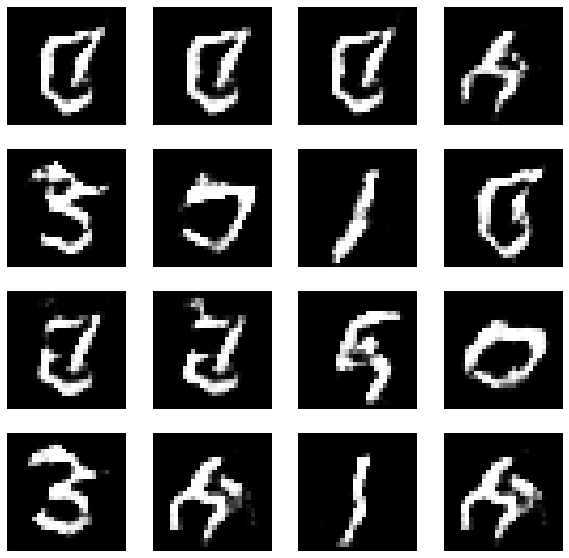

5000: [discriminator loss: 0.6709933876991272, acc: 0.296875] [gan loss: 0.993735, acc: 0.078125]
5001: [discriminator loss: 0.6760852932929993, acc: 0.4453125] [gan loss: 0.765206, acc: 0.328125]
5002: [discriminator loss: 0.7135997414588928, acc: 0.1875] [gan loss: 1.079081, acc: 0.000000]
5003: [discriminator loss: 0.6624898910522461, acc: 0.4609375] [gan loss: 0.903203, acc: 0.125000]
5004: [discriminator loss: 0.7032480239868164, acc: 0.25] [gan loss: 1.019034, acc: 0.015625]
5005: [discriminator loss: 0.6840026378631592, acc: 0.40625] [gan loss: 0.825338, acc: 0.250000]
5006: [discriminator loss: 0.6927295923233032, acc: 0.2265625] [gan loss: 1.236912, acc: 0.000000]
5007: [discriminator loss: 0.6667577028274536, acc: 0.4921875] [gan loss: 0.687002, acc: 0.531250]
5008: [discriminator loss: 0.6986774206161499, acc: 0.1171875] [gan loss: 1.250549, acc: 0.000000]
5009: [discriminator loss: 0.6594330668449402, acc: 0.5] [gan loss: 0.775449, acc: 0.406250]
5010: [discriminator loss: 

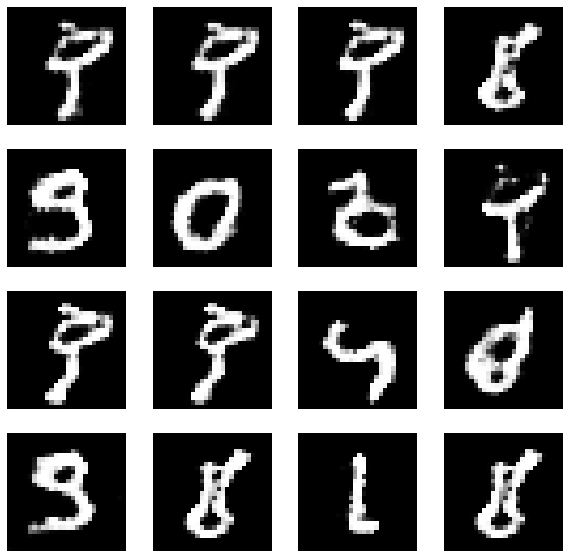

5500: [discriminator loss: 0.6727849245071411, acc: 0.2109375] [gan loss: 1.156207, acc: 0.000000]
5501: [discriminator loss: 0.6480385661125183, acc: 0.453125] [gan loss: 0.906731, acc: 0.000000]
5502: [discriminator loss: 0.6710706949234009, acc: 0.328125] [gan loss: 1.069410, acc: 0.000000]
5503: [discriminator loss: 0.6535747051239014, acc: 0.484375] [gan loss: 0.774283, acc: 0.359375]
5504: [discriminator loss: 0.6933364868164062, acc: 0.203125] [gan loss: 1.278980, acc: 0.000000]
5505: [discriminator loss: 0.6830582022666931, acc: 0.5] [gan loss: 0.695880, acc: 0.593750]
5506: [discriminator loss: 0.6980574727058411, acc: 0.109375] [gan loss: 1.369721, acc: 0.000000]
5507: [discriminator loss: 0.7017179131507874, acc: 0.5] [gan loss: 0.646976, acc: 0.656250]
5508: [discriminator loss: 0.7398278713226318, acc: 0.0234375] [gan loss: 1.286111, acc: 0.000000]
5509: [discriminator loss: 0.7068724632263184, acc: 0.4921875] [gan loss: 0.684591, acc: 0.546875]
5510: [discriminator loss: 

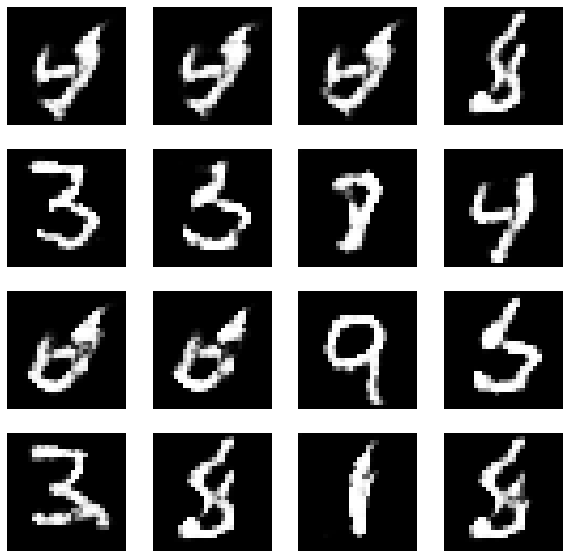

6000: [discriminator loss: 0.712367057800293, acc: 0.421875] [gan loss: 0.914185, acc: 0.156250]
6001: [discriminator loss: 0.6710097789764404, acc: 0.3203125] [gan loss: 1.070212, acc: 0.000000]
6002: [discriminator loss: 0.6882451772689819, acc: 0.4296875] [gan loss: 0.880731, acc: 0.093750]
6003: [discriminator loss: 0.7035449147224426, acc: 0.2421875] [gan loss: 1.267133, acc: 0.031250]
6004: [discriminator loss: 0.6645723581314087, acc: 0.46875] [gan loss: 0.732366, acc: 0.296875]
6005: [discriminator loss: 0.7475007772445679, acc: 0.1953125] [gan loss: 1.388842, acc: 0.000000]
6006: [discriminator loss: 0.6768527626991272, acc: 0.5] [gan loss: 0.621477, acc: 0.656250]
6007: [discriminator loss: 0.711197018623352, acc: 0.0625] [gan loss: 1.632869, acc: 0.000000]
6008: [discriminator loss: 0.7128483057022095, acc: 0.5] [gan loss: 0.571957, acc: 0.765625]
6009: [discriminator loss: 0.7361660003662109, acc: 0.0078125] [gan loss: 1.253733, acc: 0.000000]
6010: [discriminator loss: 0.6

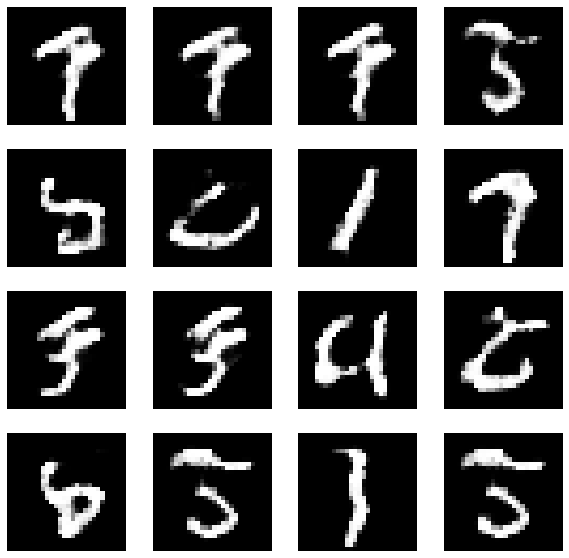

6500: [discriminator loss: 0.6600509285926819, acc: 0.2890625] [gan loss: 1.113146, acc: 0.000000]
6501: [discriminator loss: 0.638605535030365, acc: 0.4921875] [gan loss: 0.753211, acc: 0.453125]
6502: [discriminator loss: 0.6903561353683472, acc: 0.0859375] [gan loss: 1.447349, acc: 0.000000]
6503: [discriminator loss: 0.6679741144180298, acc: 0.5] [gan loss: 0.647941, acc: 0.593750]
6504: [discriminator loss: 0.7131001949310303, acc: 0.0390625] [gan loss: 1.515763, acc: 0.000000]
6505: [discriminator loss: 0.6839751601219177, acc: 0.4765625] [gan loss: 0.723583, acc: 0.468750]
6506: [discriminator loss: 0.7598471641540527, acc: 0.0859375] [gan loss: 1.379374, acc: 0.000000]
6507: [discriminator loss: 0.67177414894104, acc: 0.4921875] [gan loss: 0.729374, acc: 0.406250]
6508: [discriminator loss: 0.720973789691925, acc: 0.078125] [gan loss: 1.345478, acc: 0.000000]
6509: [discriminator loss: 0.6742278933525085, acc: 0.5] [gan loss: 0.684256, acc: 0.687500]
6510: [discriminator loss: 

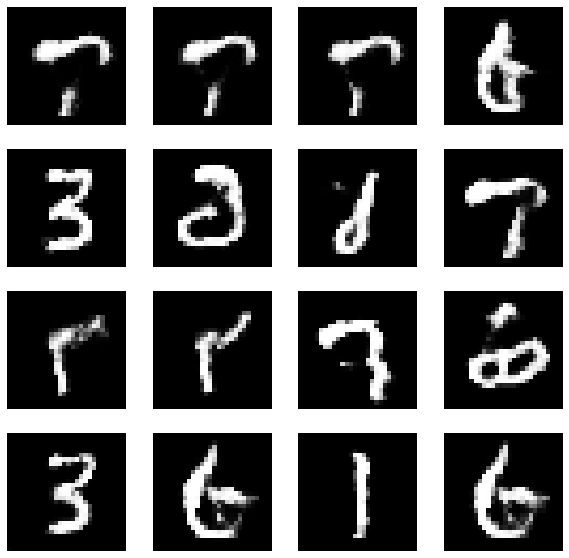

7000: [discriminator loss: 0.6844497919082642, acc: 0.5] [gan loss: 0.644328, acc: 0.562500]
7001: [discriminator loss: 0.7351311445236206, acc: 0.03125] [gan loss: 1.229056, acc: 0.000000]
7002: [discriminator loss: 0.6983495354652405, acc: 0.4921875] [gan loss: 0.655310, acc: 0.640625]
7003: [discriminator loss: 0.6978636384010315, acc: 0.1015625] [gan loss: 1.246647, acc: 0.000000]
7004: [discriminator loss: 0.6650463342666626, acc: 0.5] [gan loss: 0.804637, acc: 0.312500]
7005: [discriminator loss: 0.7167693376541138, acc: 0.1484375] [gan loss: 1.133393, acc: 0.015625]
7006: [discriminator loss: 0.6750574111938477, acc: 0.4765625] [gan loss: 0.734660, acc: 0.421875]
7007: [discriminator loss: 0.6944423317909241, acc: 0.1328125] [gan loss: 1.187240, acc: 0.000000]
7008: [discriminator loss: 0.701331377029419, acc: 0.5] [gan loss: 0.681054, acc: 0.578125]
7009: [discriminator loss: 0.7203255891799927, acc: 0.0703125] [gan loss: 1.246881, acc: 0.000000]
7010: [discriminator loss: 0.69

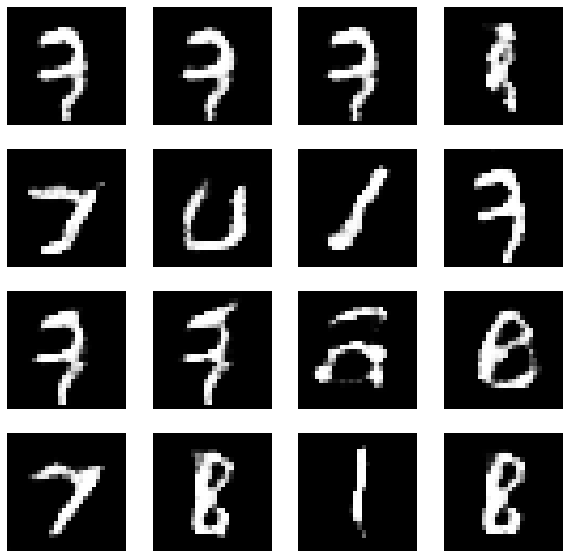

7500: [discriminator loss: 0.6641299724578857, acc: 0.4375] [gan loss: 0.819105, acc: 0.281250]
7501: [discriminator loss: 0.6762192249298096, acc: 0.21875] [gan loss: 1.153036, acc: 0.000000]
7502: [discriminator loss: 0.6766387224197388, acc: 0.484375] [gan loss: 0.798732, acc: 0.234375]
7503: [discriminator loss: 0.6942844390869141, acc: 0.1875] [gan loss: 1.327752, acc: 0.000000]
7504: [discriminator loss: 0.6907756328582764, acc: 0.5] [gan loss: 0.636087, acc: 0.609375]
7505: [discriminator loss: 0.7191888093948364, acc: 0.0234375] [gan loss: 1.168096, acc: 0.000000]
7506: [discriminator loss: 0.6739544868469238, acc: 0.5] [gan loss: 0.710866, acc: 0.359375]
7507: [discriminator loss: 0.7151142358779907, acc: 0.109375] [gan loss: 1.091721, acc: 0.000000]
7508: [discriminator loss: 0.6731943488121033, acc: 0.4609375] [gan loss: 0.726851, acc: 0.406250]
7509: [discriminator loss: 0.7023928165435791, acc: 0.1328125] [gan loss: 1.204861, acc: 0.000000]
7510: [discriminator loss: 0.690

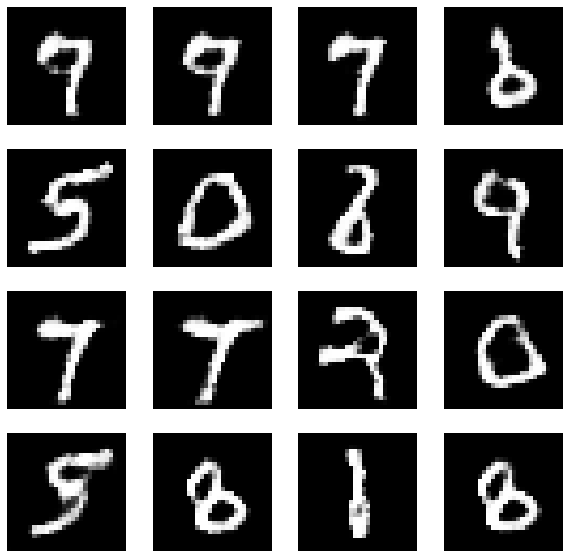

8000: [discriminator loss: 0.7375251054763794, acc: 0.0546875] [gan loss: 1.100526, acc: 0.000000]
8001: [discriminator loss: 0.6882218718528748, acc: 0.4453125] [gan loss: 0.717287, acc: 0.500000]
8002: [discriminator loss: 0.7310070991516113, acc: 0.09375] [gan loss: 1.040313, acc: 0.031250]
8003: [discriminator loss: 0.6916795372962952, acc: 0.46875] [gan loss: 0.834611, acc: 0.125000]
8004: [discriminator loss: 0.6856237649917603, acc: 0.296875] [gan loss: 1.074570, acc: 0.000000]
8005: [discriminator loss: 0.6730738878250122, acc: 0.484375] [gan loss: 0.745891, acc: 0.296875]
8006: [discriminator loss: 0.7218731641769409, acc: 0.0625] [gan loss: 1.186365, acc: 0.000000]
8007: [discriminator loss: 0.7167985439300537, acc: 0.4921875] [gan loss: 0.606576, acc: 0.718750]
8008: [discriminator loss: 0.7473698854446411, acc: 0.03125] [gan loss: 1.278065, acc: 0.000000]
8009: [discriminator loss: 0.6829448938369751, acc: 0.4921875] [gan loss: 0.619177, acc: 0.671875]
8010: [discriminator 

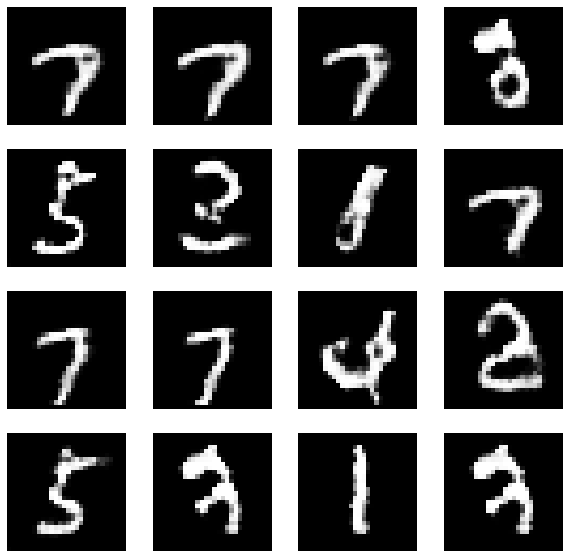

8500: [discriminator loss: 0.6071224808692932, acc: 0.4765625] [gan loss: 0.859256, acc: 0.203125]
8501: [discriminator loss: 0.6233447790145874, acc: 0.3046875] [gan loss: 1.421012, acc: 0.000000]
8502: [discriminator loss: 0.6408816576004028, acc: 0.5] [gan loss: 0.558878, acc: 0.718750]
8503: [discriminator loss: 0.7578458786010742, acc: 0.0078125] [gan loss: 1.688392, acc: 0.000000]
8504: [discriminator loss: 0.6848776340484619, acc: 0.5] [gan loss: 0.726947, acc: 0.375000]
8505: [discriminator loss: 0.7017486095428467, acc: 0.0859375] [gan loss: 1.270599, acc: 0.000000]
8506: [discriminator loss: 0.6694583296775818, acc: 0.4296875] [gan loss: 0.790908, acc: 0.328125]
8507: [discriminator loss: 0.6518344879150391, acc: 0.21875] [gan loss: 1.107057, acc: 0.031250]
8508: [discriminator loss: 0.6510745286941528, acc: 0.4296875] [gan loss: 0.895098, acc: 0.125000]
8509: [discriminator loss: 0.6550875902175903, acc: 0.296875] [gan loss: 1.081151, acc: 0.015625]
8510: [discriminator loss

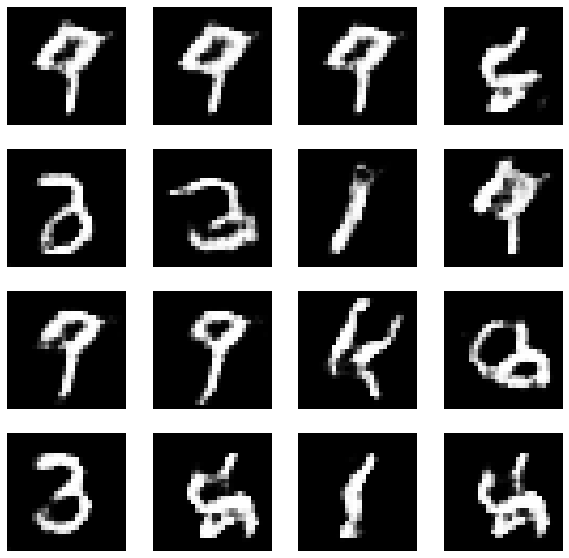

9000: [discriminator loss: 0.6840376257896423, acc: 0.5] [gan loss: 0.728602, acc: 0.296875]
9001: [discriminator loss: 0.7082120180130005, acc: 0.1484375] [gan loss: 1.250019, acc: 0.000000]
9002: [discriminator loss: 0.6637611389160156, acc: 0.5] [gan loss: 0.580380, acc: 0.765625]
9003: [discriminator loss: 0.7346194386482239, acc: 0.0078125] [gan loss: 1.350693, acc: 0.015625]
9004: [discriminator loss: 0.7149366736412048, acc: 0.4453125] [gan loss: 0.697090, acc: 0.453125]
9005: [discriminator loss: 0.7021950483322144, acc: 0.09375] [gan loss: 1.231414, acc: 0.000000]
9006: [discriminator loss: 0.674855649471283, acc: 0.5] [gan loss: 0.752444, acc: 0.359375]
9007: [discriminator loss: 0.7001685500144958, acc: 0.1484375] [gan loss: 1.149007, acc: 0.000000]
9008: [discriminator loss: 0.6292799115180969, acc: 0.5] [gan loss: 0.776645, acc: 0.343750]
9009: [discriminator loss: 0.6993613839149475, acc: 0.1328125] [gan loss: 1.125067, acc: 0.000000]
9010: [discriminator loss: 0.67733037

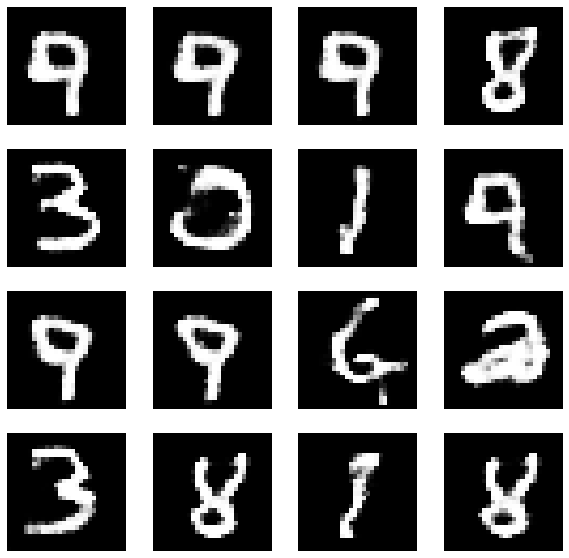

9500: [discriminator loss: 0.7537655234336853, acc: 0.03125] [gan loss: 1.273344, acc: 0.000000]
9501: [discriminator loss: 0.7014048099517822, acc: 0.5] [gan loss: 0.725871, acc: 0.531250]
9502: [discriminator loss: 0.715710461139679, acc: 0.0703125] [gan loss: 1.210663, acc: 0.000000]
9503: [discriminator loss: 0.7017154693603516, acc: 0.4921875] [gan loss: 0.639000, acc: 0.750000]
9504: [discriminator loss: 0.7167276740074158, acc: 0.0546875] [gan loss: 1.193684, acc: 0.000000]
9505: [discriminator loss: 0.680350124835968, acc: 0.5] [gan loss: 0.732592, acc: 0.328125]
9506: [discriminator loss: 0.689355194568634, acc: 0.1015625] [gan loss: 1.106905, acc: 0.000000]
9507: [discriminator loss: 0.6587503552436829, acc: 0.5] [gan loss: 0.820889, acc: 0.171875]
9508: [discriminator loss: 0.6884478330612183, acc: 0.2578125] [gan loss: 1.072033, acc: 0.000000]
9509: [discriminator loss: 0.6676737666130066, acc: 0.5] [gan loss: 0.850737, acc: 0.125000]
9510: [discriminator loss: 0.6914023756

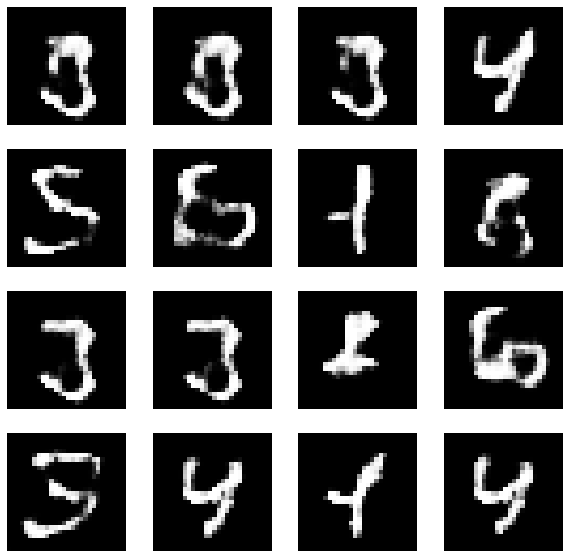

10000: [discriminator loss: 0.668063759803772, acc: 0.5] [gan loss: 0.572573, acc: 0.843750]
10001: [discriminator loss: 0.7395830154418945, acc: 0.03125] [gan loss: 1.271130, acc: 0.000000]
10002: [discriminator loss: 0.6567538976669312, acc: 0.5] [gan loss: 0.653660, acc: 0.656250]
10003: [discriminator loss: 0.6848647594451904, acc: 0.0859375] [gan loss: 1.166423, acc: 0.000000]
10004: [discriminator loss: 0.6494942307472229, acc: 0.5] [gan loss: 0.724803, acc: 0.515625]
10005: [discriminator loss: 0.7015781402587891, acc: 0.171875] [gan loss: 1.127858, acc: 0.046875]
10006: [discriminator loss: 0.655037522315979, acc: 0.4375] [gan loss: 0.832535, acc: 0.234375]
10007: [discriminator loss: 0.6740249395370483, acc: 0.328125] [gan loss: 1.023345, acc: 0.062500]
10008: [discriminator loss: 0.6704411506652832, acc: 0.3671875] [gan loss: 0.932465, acc: 0.062500]
10009: [discriminator loss: 0.6618638038635254, acc: 0.2734375] [gan loss: 1.140120, acc: 0.000000]
10010: [discriminator loss:

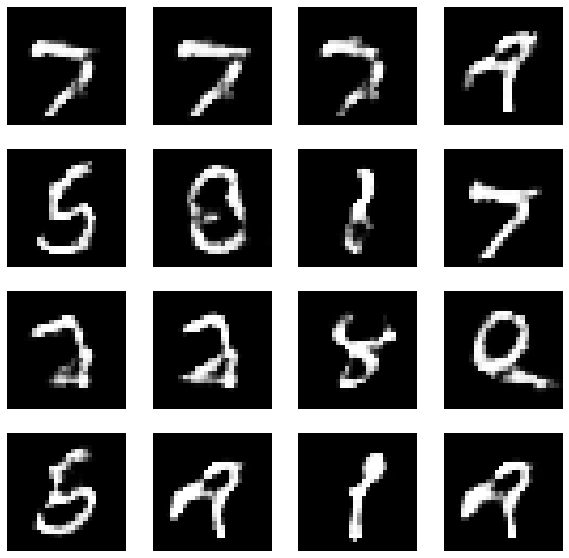

10500: [discriminator loss: 0.6693560481071472, acc: 0.5] [gan loss: 0.682816, acc: 0.531250]
10501: [discriminator loss: 0.688271164894104, acc: 0.078125] [gan loss: 1.128779, acc: 0.000000]
10502: [discriminator loss: 0.6434694528579712, acc: 0.4921875] [gan loss: 0.772116, acc: 0.281250]
10503: [discriminator loss: 0.6797630190849304, acc: 0.1796875] [gan loss: 1.125654, acc: 0.000000]
10504: [discriminator loss: 0.6591885685920715, acc: 0.484375] [gan loss: 0.770396, acc: 0.312500]
10505: [discriminator loss: 0.6809749603271484, acc: 0.2421875] [gan loss: 1.089143, acc: 0.000000]
10506: [discriminator loss: 0.6522141695022583, acc: 0.4765625] [gan loss: 0.832642, acc: 0.125000]
10507: [discriminator loss: 0.664115846157074, acc: 0.2109375] [gan loss: 1.165289, acc: 0.000000]
10508: [discriminator loss: 0.6503828763961792, acc: 0.4921875] [gan loss: 0.763656, acc: 0.281250]
10509: [discriminator loss: 0.6914878487586975, acc: 0.171875] [gan loss: 1.241016, acc: 0.000000]
10510: [dis

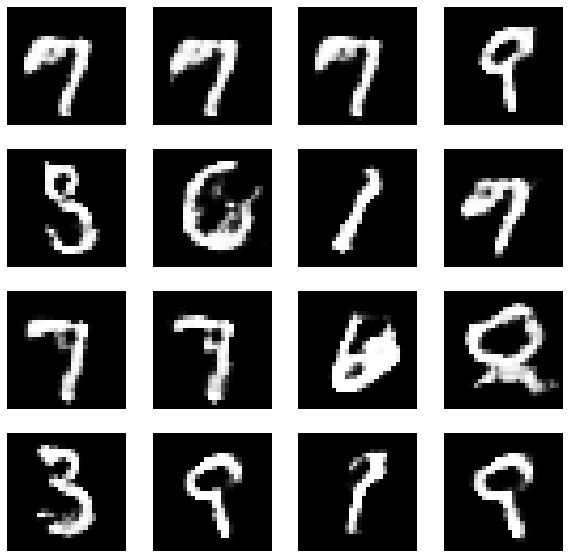

11000: [discriminator loss: 0.7154407501220703, acc: 0.125] [gan loss: 1.545097, acc: 0.000000]
11001: [discriminator loss: 0.7047649621963501, acc: 0.4921875] [gan loss: 0.508836, acc: 0.937500]
11002: [discriminator loss: 0.7734144926071167, acc: 0.0] [gan loss: 1.327934, acc: 0.000000]
11003: [discriminator loss: 0.7050835490226746, acc: 0.4921875] [gan loss: 0.750670, acc: 0.406250]
11004: [discriminator loss: 0.6961659789085388, acc: 0.125] [gan loss: 1.211520, acc: 0.000000]
11005: [discriminator loss: 0.6895723342895508, acc: 0.4765625] [gan loss: 0.752214, acc: 0.390625]
11006: [discriminator loss: 0.6860527992248535, acc: 0.2265625] [gan loss: 1.092266, acc: 0.000000]
11007: [discriminator loss: 0.691126823425293, acc: 0.4453125] [gan loss: 0.723441, acc: 0.468750]
11008: [discriminator loss: 0.701011061668396, acc: 0.1328125] [gan loss: 1.083681, acc: 0.015625]
11009: [discriminator loss: 0.6603288054466248, acc: 0.4609375] [gan loss: 0.740526, acc: 0.328125]
11010: [discrimi

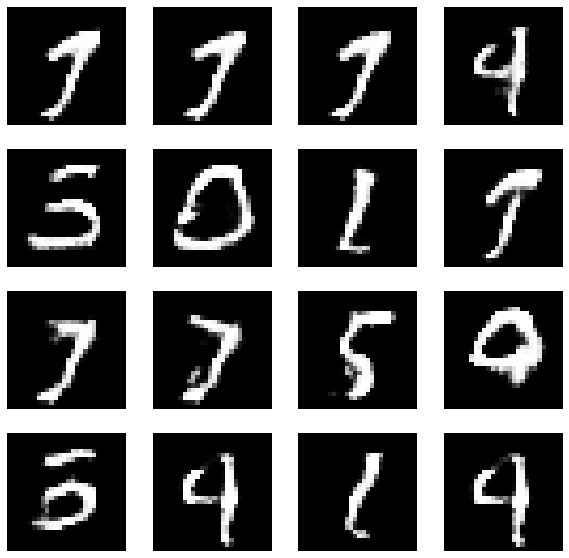

11500: [discriminator loss: 0.6949228048324585, acc: 0.109375] [gan loss: 1.146006, acc: 0.000000]
11501: [discriminator loss: 0.6556935906410217, acc: 0.4609375] [gan loss: 0.789703, acc: 0.265625]
11502: [discriminator loss: 0.6550297737121582, acc: 0.1875] [gan loss: 1.114838, acc: 0.000000]
11503: [discriminator loss: 0.6613814234733582, acc: 0.453125] [gan loss: 0.793906, acc: 0.328125]
11504: [discriminator loss: 0.7265461683273315, acc: 0.125] [gan loss: 1.393959, acc: 0.000000]
11505: [discriminator loss: 0.6956011652946472, acc: 0.5] [gan loss: 0.678395, acc: 0.531250]
11506: [discriminator loss: 0.7521559000015259, acc: 0.0703125] [gan loss: 1.365023, acc: 0.000000]
11507: [discriminator loss: 0.6804386973381042, acc: 0.5] [gan loss: 0.728506, acc: 0.421875]
11508: [discriminator loss: 0.7226583957672119, acc: 0.09375] [gan loss: 1.322804, acc: 0.000000]
11509: [discriminator loss: 0.6874874830245972, acc: 0.5] [gan loss: 0.741996, acc: 0.343750]
11510: [discriminator loss: 0

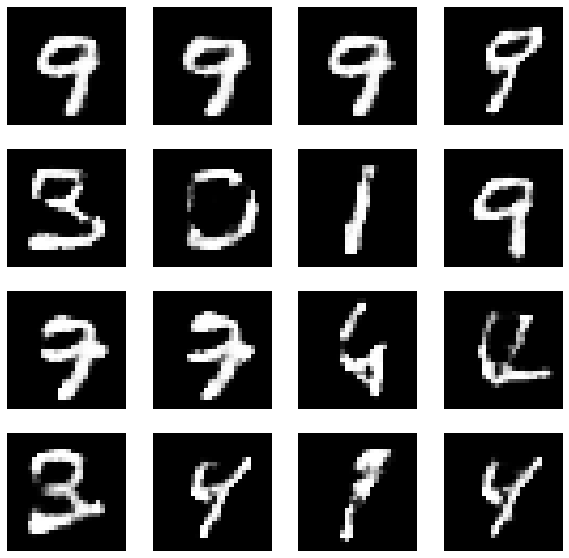

12000: [discriminator loss: 0.7216329574584961, acc: 0.03125] [gan loss: 1.155873, acc: 0.000000]
12001: [discriminator loss: 0.6510363221168518, acc: 0.5] [gan loss: 0.366038, acc: 0.968750]
12002: [discriminator loss: 0.7437002658843994, acc: 0.078125] [gan loss: 1.041962, acc: 0.046875]
12003: [discriminator loss: 0.5972079634666443, acc: 0.5] [gan loss: 0.349529, acc: 0.937500]
12004: [discriminator loss: 0.6406514048576355, acc: 0.1796875] [gan loss: 0.804650, acc: 0.296875]
12005: [discriminator loss: 0.6306630969047546, acc: 0.5] [gan loss: 0.355332, acc: 0.937500]
12006: [discriminator loss: 0.6795185804367065, acc: 0.1484375] [gan loss: 0.957561, acc: 0.062500]
12007: [discriminator loss: 0.6428132057189941, acc: 0.5] [gan loss: 0.344880, acc: 1.000000]
12008: [discriminator loss: 0.684814453125, acc: 0.078125] [gan loss: 0.896974, acc: 0.187500]
12009: [discriminator loss: 0.6386149525642395, acc: 0.5] [gan loss: 0.365480, acc: 0.984375]
12010: [discriminator loss: 0.72955489

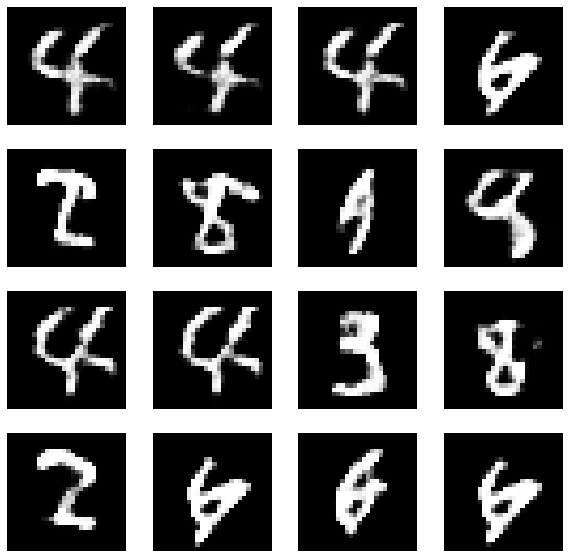

12500: [discriminator loss: 0.6614695191383362, acc: 0.4765625] [gan loss: 0.791808, acc: 0.328125]
12501: [discriminator loss: 0.6772291660308838, acc: 0.1953125] [gan loss: 1.376655, acc: 0.000000]
12502: [discriminator loss: 0.5873012542724609, acc: 0.5] [gan loss: 0.553351, acc: 0.781250]
12503: [discriminator loss: 0.7415283918380737, acc: 0.015625] [gan loss: 1.764634, acc: 0.000000]
12504: [discriminator loss: 0.6818723678588867, acc: 0.5] [gan loss: 0.566359, acc: 0.781250]
12505: [discriminator loss: 0.7252340316772461, acc: 0.0546875] [gan loss: 1.395169, acc: 0.000000]
12506: [discriminator loss: 0.6569219827651978, acc: 0.5] [gan loss: 0.745818, acc: 0.390625]
12507: [discriminator loss: 0.6837740540504456, acc: 0.1875] [gan loss: 1.282299, acc: 0.000000]
12508: [discriminator loss: 0.6341838240623474, acc: 0.484375] [gan loss: 0.869443, acc: 0.203125]
12509: [discriminator loss: 0.6422972679138184, acc: 0.328125] [gan loss: 1.000031, acc: 0.093750]
12510: [discriminator lo

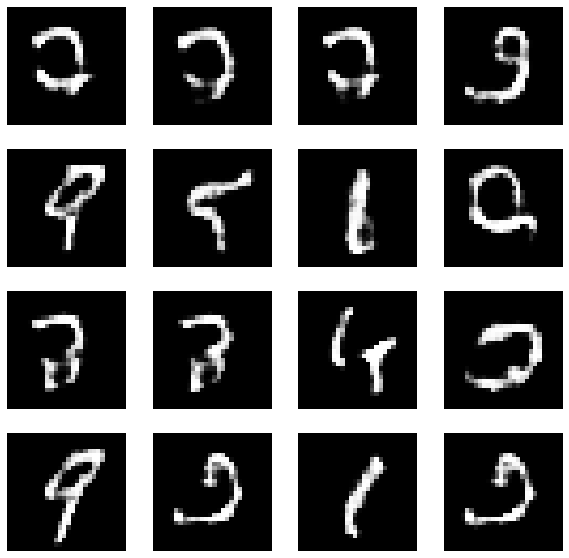

13000: [discriminator loss: 0.6001841425895691, acc: 0.359375] [gan loss: 0.895192, acc: 0.062500]
13001: [discriminator loss: 0.6507025957107544, acc: 0.2734375] [gan loss: 1.078516, acc: 0.000000]
13002: [discriminator loss: 0.5891480445861816, acc: 0.5] [gan loss: 0.817679, acc: 0.203125]
13003: [discriminator loss: 0.6772164702415466, acc: 0.21875] [gan loss: 1.223336, acc: 0.000000]
13004: [discriminator loss: 0.6296439170837402, acc: 0.4921875] [gan loss: 0.720222, acc: 0.453125]
13005: [discriminator loss: 0.650969386100769, acc: 0.140625] [gan loss: 1.329713, acc: 0.000000]
13006: [discriminator loss: 0.6332985162734985, acc: 0.5] [gan loss: 0.708164, acc: 0.500000]
13007: [discriminator loss: 0.6687011122703552, acc: 0.1484375] [gan loss: 1.324150, acc: 0.000000]
13008: [discriminator loss: 0.6746338605880737, acc: 0.5] [gan loss: 0.636895, acc: 0.625000]
13009: [discriminator loss: 0.7640804052352905, acc: 0.0625] [gan loss: 1.765723, acc: 0.000000]
13010: [discriminator loss

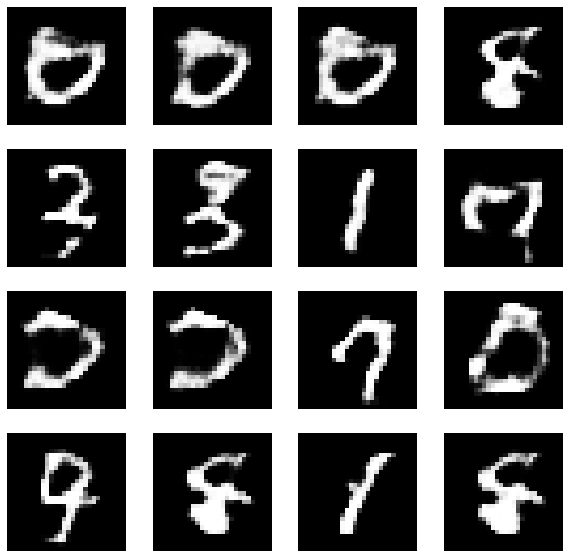

13500: [discriminator loss: 0.6422944068908691, acc: 0.5] [gan loss: 0.682130, acc: 0.546875]
13501: [discriminator loss: 0.6956034302711487, acc: 0.078125] [gan loss: 1.313322, acc: 0.000000]
13502: [discriminator loss: 0.6465629935264587, acc: 0.4765625] [gan loss: 0.691726, acc: 0.453125]
13503: [discriminator loss: 0.6798115968704224, acc: 0.09375] [gan loss: 1.450936, acc: 0.000000]
13504: [discriminator loss: 0.6397631764411926, acc: 0.5] [gan loss: 0.609392, acc: 0.718750]
13505: [discriminator loss: 0.733040452003479, acc: 0.0625] [gan loss: 1.649082, acc: 0.000000]
13506: [discriminator loss: 0.7511881589889526, acc: 0.484375] [gan loss: 0.666923, acc: 0.578125]
13507: [discriminator loss: 0.6922683715820312, acc: 0.125] [gan loss: 1.185608, acc: 0.000000]
13508: [discriminator loss: 0.6899707317352295, acc: 0.3984375] [gan loss: 0.842588, acc: 0.359375]
13509: [discriminator loss: 0.6924908757209778, acc: 0.265625] [gan loss: 1.179067, acc: 0.000000]
13510: [discriminator los

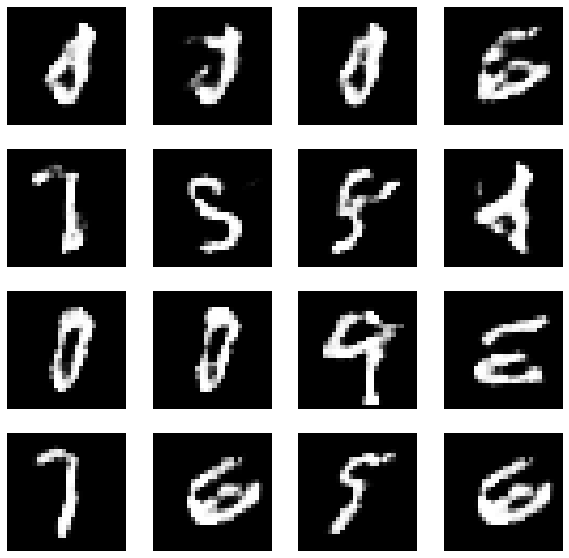

14000: [discriminator loss: 0.6808516383171082, acc: 0.46875] [gan loss: 0.771006, acc: 0.421875]
14001: [discriminator loss: 0.6818498373031616, acc: 0.1796875] [gan loss: 1.181836, acc: 0.046875]
14002: [discriminator loss: 0.6584507822990417, acc: 0.46875] [gan loss: 0.757322, acc: 0.343750]
14003: [discriminator loss: 0.7450758218765259, acc: 0.1484375] [gan loss: 1.441561, acc: 0.015625]
14004: [discriminator loss: 0.6697865724563599, acc: 0.4921875] [gan loss: 0.655239, acc: 0.562500]
14005: [discriminator loss: 0.7328702211380005, acc: 0.046875] [gan loss: 1.417547, acc: 0.000000]
14006: [discriminator loss: 0.6605331897735596, acc: 0.4921875] [gan loss: 0.604816, acc: 0.718750]
14007: [discriminator loss: 0.7518795728683472, acc: 0.0234375] [gan loss: 1.382190, acc: 0.000000]
14008: [discriminator loss: 0.7177340388298035, acc: 0.46875] [gan loss: 0.632749, acc: 0.593750]
14009: [discriminator loss: 0.6818934082984924, acc: 0.1640625] [gan loss: 1.207237, acc: 0.000000]
14010: 

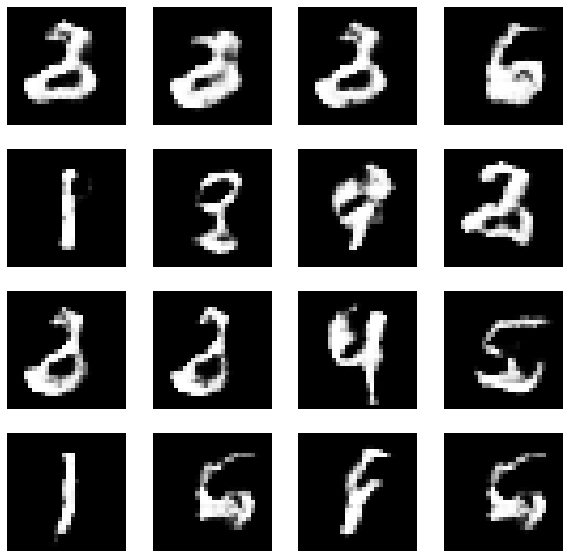

14500: [discriminator loss: 0.6277531385421753, acc: 0.2734375] [gan loss: 0.812895, acc: 0.328125]
14501: [discriminator loss: 0.5612071752548218, acc: 0.4921875] [gan loss: 0.366715, acc: 0.953125]
14502: [discriminator loss: 0.644149661064148, acc: 0.15625] [gan loss: 1.017392, acc: 0.218750]
14503: [discriminator loss: 0.5758745670318604, acc: 0.5] [gan loss: 0.414346, acc: 0.937500]
14504: [discriminator loss: 0.691429615020752, acc: 0.140625] [gan loss: 1.141264, acc: 0.015625]
14505: [discriminator loss: 0.5637931227684021, acc: 0.5] [gan loss: 0.256494, acc: 0.984375]
14506: [discriminator loss: 0.7015946507453918, acc: 0.125] [gan loss: 1.036960, acc: 0.093750]
14507: [discriminator loss: 0.6177130341529846, acc: 0.5] [gan loss: 0.392884, acc: 0.937500]
14508: [discriminator loss: 0.6432747840881348, acc: 0.1796875] [gan loss: 1.144814, acc: 0.031250]
14509: [discriminator loss: 0.6406446695327759, acc: 0.484375] [gan loss: 0.577572, acc: 0.796875]
14510: [discriminator loss: 

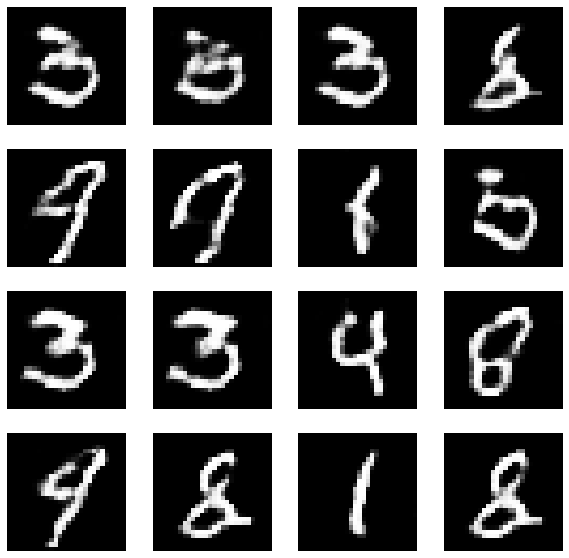

15000: [discriminator loss: 0.7047561407089233, acc: 0.4609375] [gan loss: 0.724178, acc: 0.500000]
15001: [discriminator loss: 0.7057398557662964, acc: 0.140625] [gan loss: 1.363723, acc: 0.000000]
15002: [discriminator loss: 0.6572177410125732, acc: 0.5] [gan loss: 0.747358, acc: 0.453125]
15003: [discriminator loss: 0.6643664240837097, acc: 0.21875] [gan loss: 1.147758, acc: 0.000000]
15004: [discriminator loss: 0.6994602680206299, acc: 0.3359375] [gan loss: 0.810655, acc: 0.281250]
15005: [discriminator loss: 0.6642742156982422, acc: 0.2578125] [gan loss: 1.078898, acc: 0.125000]
15006: [discriminator loss: 0.6774508953094482, acc: 0.3671875] [gan loss: 0.899478, acc: 0.125000]
15007: [discriminator loss: 0.6559693813323975, acc: 0.2734375] [gan loss: 1.211604, acc: 0.046875]
15008: [discriminator loss: 0.6487802863121033, acc: 0.4140625] [gan loss: 0.853233, acc: 0.218750]
15009: [discriminator loss: 0.6419799327850342, acc: 0.265625] [gan loss: 1.193912, acc: 0.000000]
15010: [di

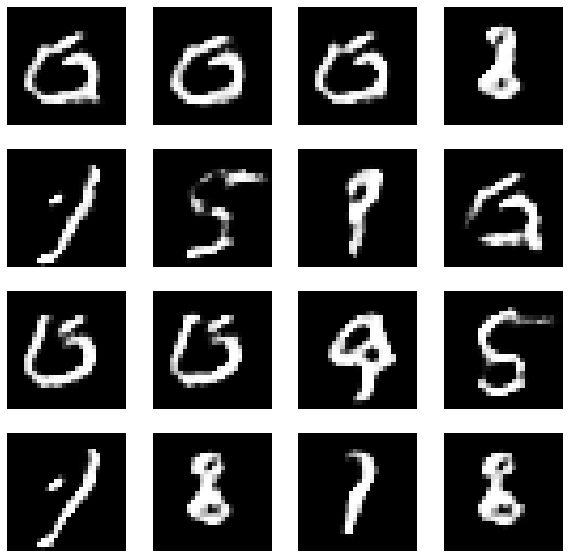

15500: [discriminator loss: 0.6240147352218628, acc: 0.390625] [gan loss: 0.980294, acc: 0.187500]
15501: [discriminator loss: 0.6061215996742249, acc: 0.3515625] [gan loss: 1.434246, acc: 0.015625]
15502: [discriminator loss: 0.6058619022369385, acc: 0.484375] [gan loss: 0.710412, acc: 0.593750]
15503: [discriminator loss: 0.6373885869979858, acc: 0.1953125] [gan loss: 1.480375, acc: 0.015625]
15504: [discriminator loss: 0.6162383556365967, acc: 0.5] [gan loss: 0.581381, acc: 0.734375]
15505: [discriminator loss: 0.7273590564727783, acc: 0.0546875] [gan loss: 1.762935, acc: 0.000000]
15506: [discriminator loss: 0.6418834328651428, acc: 0.5] [gan loss: 0.719448, acc: 0.546875]
15507: [discriminator loss: 0.6764684915542603, acc: 0.1171875] [gan loss: 1.457422, acc: 0.015625]
15508: [discriminator loss: 0.6432240009307861, acc: 0.4921875] [gan loss: 0.721526, acc: 0.484375]
15509: [discriminator loss: 0.6400728225708008, acc: 0.1640625] [gan loss: 1.300596, acc: 0.000000]
15510: [discri

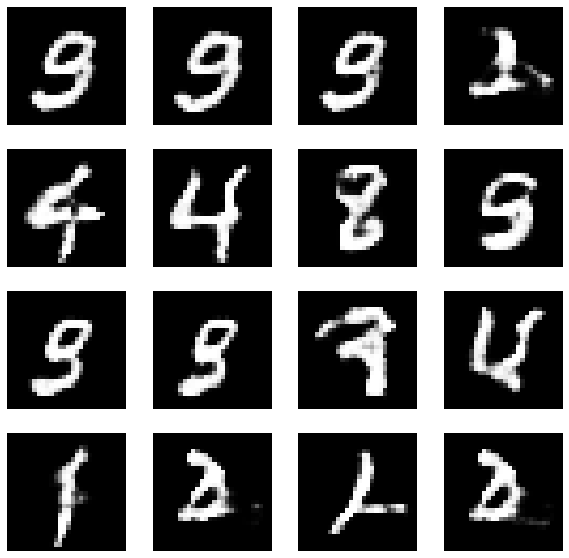

16000: [discriminator loss: 0.687414288520813, acc: 0.4453125] [gan loss: 0.858689, acc: 0.187500]
16001: [discriminator loss: 0.6630262732505798, acc: 0.203125] [gan loss: 1.184817, acc: 0.015625]
16002: [discriminator loss: 0.6760913729667664, acc: 0.4765625] [gan loss: 0.617794, acc: 0.593750]
16003: [discriminator loss: 0.7259148359298706, acc: 0.078125] [gan loss: 1.866829, acc: 0.000000]
16004: [discriminator loss: 0.7472589612007141, acc: 0.5] [gan loss: 0.456483, acc: 0.937500]
16005: [discriminator loss: 0.8043507933616638, acc: 0.03125] [gan loss: 1.522795, acc: 0.000000]
16006: [discriminator loss: 0.7006745934486389, acc: 0.4921875] [gan loss: 0.591473, acc: 0.828125]
16007: [discriminator loss: 0.6179587841033936, acc: 0.203125] [gan loss: 0.892601, acc: 0.078125]
16008: [discriminator loss: 0.7023002505302429, acc: 0.2421875] [gan loss: 1.195294, acc: 0.000000]
16009: [discriminator loss: 0.7094223499298096, acc: 0.4609375] [gan loss: 0.748170, acc: 0.359375]
16010: [disc

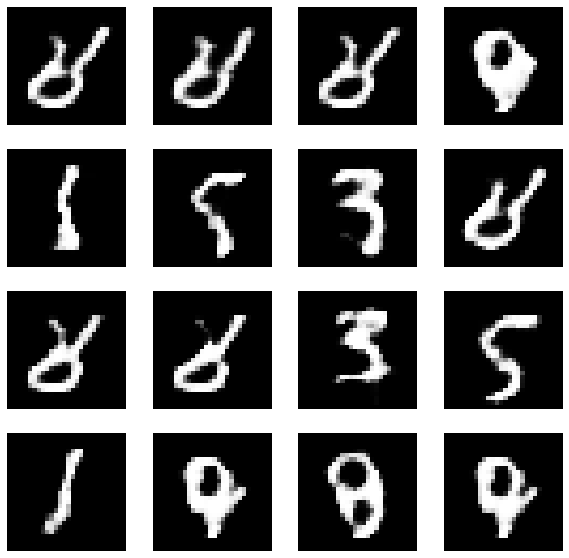

16500: [discriminator loss: 0.6620160341262817, acc: 0.4765625] [gan loss: 0.704430, acc: 0.531250]
16501: [discriminator loss: 0.6699094772338867, acc: 0.2265625] [gan loss: 1.170625, acc: 0.031250]
16502: [discriminator loss: 0.6331667900085449, acc: 0.484375] [gan loss: 0.650433, acc: 0.609375]
16503: [discriminator loss: 0.7161530256271362, acc: 0.1171875] [gan loss: 1.127084, acc: 0.046875]
16504: [discriminator loss: 0.6582072973251343, acc: 0.4609375] [gan loss: 0.661899, acc: 0.515625]
16505: [discriminator loss: 0.7113004326820374, acc: 0.2109375] [gan loss: 0.967670, acc: 0.203125]
16506: [discriminator loss: 0.6821033954620361, acc: 0.390625] [gan loss: 0.890689, acc: 0.296875]
16507: [discriminator loss: 0.6792701482772827, acc: 0.3359375] [gan loss: 0.775177, acc: 0.375000]
16508: [discriminator loss: 0.7421019673347473, acc: 0.1875] [gan loss: 1.169218, acc: 0.078125]
16509: [discriminator loss: 0.712958812713623, acc: 0.375] [gan loss: 0.820084, acc: 0.375000]
16510: [di

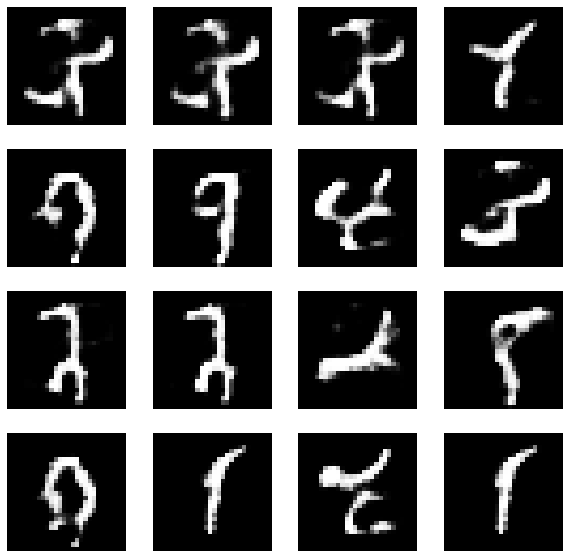

17000: [discriminator loss: 0.5730515718460083, acc: 0.2734375] [gan loss: 1.233229, acc: 0.031250]
17001: [discriminator loss: 0.5633137226104736, acc: 0.484375] [gan loss: 0.920293, acc: 0.203125]
17002: [discriminator loss: 0.5528093576431274, acc: 0.328125] [gan loss: 1.258953, acc: 0.093750]
17003: [discriminator loss: 0.5960254669189453, acc: 0.390625] [gan loss: 0.990484, acc: 0.203125]
17004: [discriminator loss: 0.5482566356658936, acc: 0.3671875] [gan loss: 1.138495, acc: 0.046875]
17005: [discriminator loss: 0.5390529036521912, acc: 0.390625] [gan loss: 1.146761, acc: 0.031250]
17006: [discriminator loss: 0.5532304048538208, acc: 0.421875] [gan loss: 1.143513, acc: 0.109375]
17007: [discriminator loss: 0.5718091130256653, acc: 0.4296875] [gan loss: 1.196714, acc: 0.031250]
17008: [discriminator loss: 0.5795650482177734, acc: 0.3984375] [gan loss: 1.140408, acc: 0.093750]
17009: [discriminator loss: 0.5716819167137146, acc: 0.390625] [gan loss: 1.192583, acc: 0.078125]
17010:

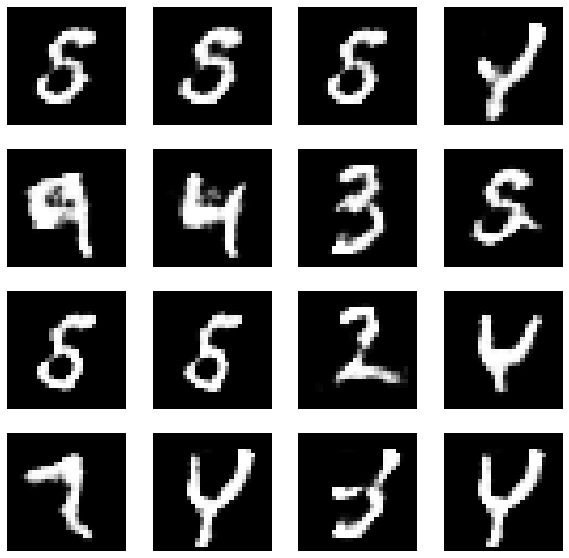

17500: [discriminator loss: 0.7106326222419739, acc: 0.078125] [gan loss: 1.589003, acc: 0.015625]
17501: [discriminator loss: 0.6158537864685059, acc: 0.4921875] [gan loss: 0.663773, acc: 0.500000]
17502: [discriminator loss: 0.6906431913375854, acc: 0.1171875] [gan loss: 1.482138, acc: 0.000000]
17503: [discriminator loss: 0.5753433704376221, acc: 0.4765625] [gan loss: 0.870523, acc: 0.265625]
17504: [discriminator loss: 0.6334776878356934, acc: 0.34375] [gan loss: 1.349604, acc: 0.078125]
17505: [discriminator loss: 0.6291956901550293, acc: 0.4453125] [gan loss: 0.797890, acc: 0.375000]
17506: [discriminator loss: 0.6348426938056946, acc: 0.2734375] [gan loss: 1.592554, acc: 0.062500]
17507: [discriminator loss: 0.5994347929954529, acc: 0.46875] [gan loss: 0.734824, acc: 0.453125]
17508: [discriminator loss: 0.6633334159851074, acc: 0.2265625] [gan loss: 1.653757, acc: 0.000000]
17509: [discriminator loss: 0.5602063536643982, acc: 0.4921875] [gan loss: 0.920478, acc: 0.312500]
17510

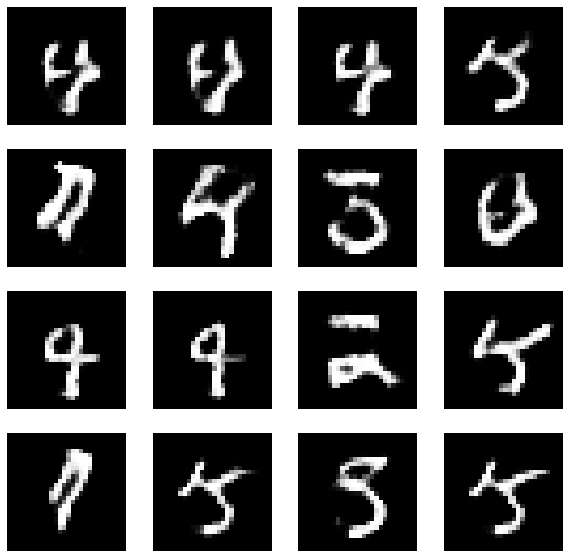

18000: [discriminator loss: 0.666409969329834, acc: 0.1875] [gan loss: 1.656605, acc: 0.000000]
18001: [discriminator loss: 0.6130346655845642, acc: 0.4609375] [gan loss: 0.944557, acc: 0.265625]
18002: [discriminator loss: 0.6780069470405579, acc: 0.2265625] [gan loss: 1.552306, acc: 0.000000]
18003: [discriminator loss: 0.6275836825370789, acc: 0.421875] [gan loss: 0.956912, acc: 0.218750]
18004: [discriminator loss: 0.6859189867973328, acc: 0.25] [gan loss: 1.252511, acc: 0.031250]
18005: [discriminator loss: 0.6228674650192261, acc: 0.3828125] [gan loss: 0.998163, acc: 0.203125]
18006: [discriminator loss: 0.6518130302429199, acc: 0.2890625] [gan loss: 1.254536, acc: 0.031250]
18007: [discriminator loss: 0.590705931186676, acc: 0.4140625] [gan loss: 1.222210, acc: 0.125000]
18008: [discriminator loss: 0.6169688105583191, acc: 0.3515625] [gan loss: 1.423258, acc: 0.093750]
18009: [discriminator loss: 0.72845858335495, acc: 0.40625] [gan loss: 0.840709, acc: 0.312500]
18010: [discrim

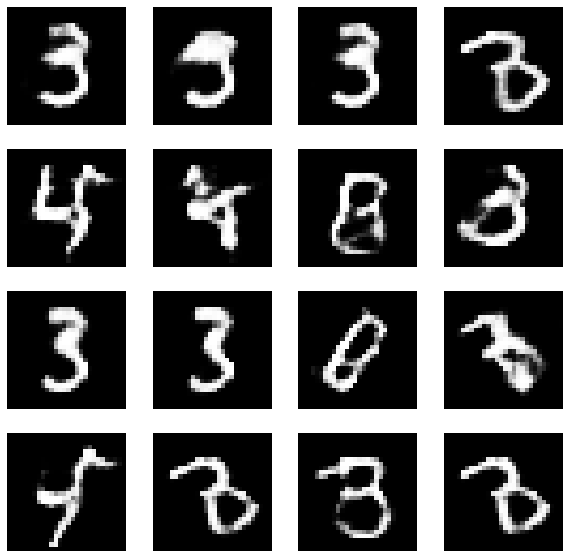

18500: [discriminator loss: 0.7369572520256042, acc: 0.46875] [gan loss: 0.490779, acc: 0.875000]
18501: [discriminator loss: 0.701922595500946, acc: 0.125] [gan loss: 1.446895, acc: 0.015625]
18502: [discriminator loss: 0.6130278706550598, acc: 0.5] [gan loss: 0.478737, acc: 0.875000]
18503: [discriminator loss: 0.7124155163764954, acc: 0.125] [gan loss: 1.129829, acc: 0.062500]
18504: [discriminator loss: 0.6904220581054688, acc: 0.4296875] [gan loss: 0.606204, acc: 0.703125]
18505: [discriminator loss: 0.661518931388855, acc: 0.171875] [gan loss: 1.196241, acc: 0.046875]
18506: [discriminator loss: 0.6543340682983398, acc: 0.46875] [gan loss: 0.538556, acc: 0.828125]
18507: [discriminator loss: 0.719433069229126, acc: 0.09375] [gan loss: 1.386642, acc: 0.015625]
18508: [discriminator loss: 0.6005425453186035, acc: 0.5] [gan loss: 0.535754, acc: 0.875000]
18509: [discriminator loss: 0.7097420692443848, acc: 0.1171875] [gan loss: 1.328012, acc: 0.000000]
18510: [discriminator loss: 0.

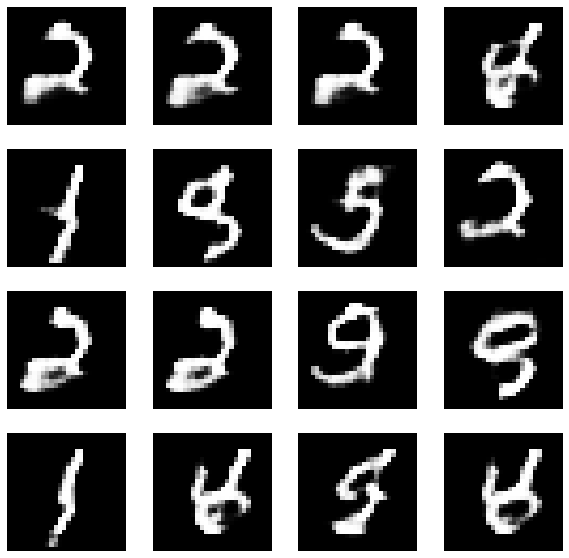

19000: [discriminator loss: 0.8725314736366272, acc: 0.0390625] [gan loss: 1.987905, acc: 0.046875]
19001: [discriminator loss: 0.750705897808075, acc: 0.421875] [gan loss: 0.745838, acc: 0.468750]
19002: [discriminator loss: 0.7078889608383179, acc: 0.1484375] [gan loss: 1.484203, acc: 0.046875]
19003: [discriminator loss: 0.6836096048355103, acc: 0.4453125] [gan loss: 0.765683, acc: 0.421875]
19004: [discriminator loss: 0.6475486159324646, acc: 0.21875] [gan loss: 1.539171, acc: 0.046875]
19005: [discriminator loss: 0.632928192615509, acc: 0.453125] [gan loss: 0.786984, acc: 0.453125]
19006: [discriminator loss: 0.6737346053123474, acc: 0.1953125] [gan loss: 1.621918, acc: 0.046875]
19007: [discriminator loss: 0.6207094788551331, acc: 0.453125] [gan loss: 0.721074, acc: 0.468750]
19008: [discriminator loss: 0.710268497467041, acc: 0.125] [gan loss: 1.764409, acc: 0.000000]
19009: [discriminator loss: 0.6216129064559937, acc: 0.4921875] [gan loss: 0.710950, acc: 0.453125]
19010: [disc

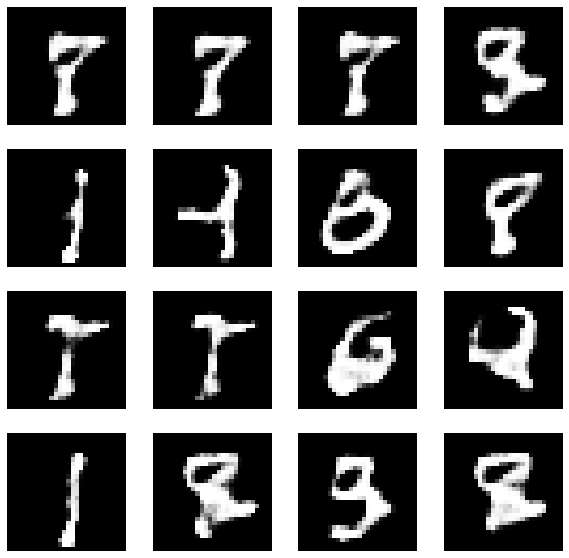

19500: [discriminator loss: 0.7001512050628662, acc: 0.5] [gan loss: 0.127676, acc: 1.000000]
19501: [discriminator loss: 0.6692948341369629, acc: 0.2109375] [gan loss: 0.815235, acc: 0.312500]
19502: [discriminator loss: 0.6003434658050537, acc: 0.5] [gan loss: 0.180281, acc: 0.953125]
19503: [discriminator loss: 0.5793275237083435, acc: 0.3203125] [gan loss: 0.620658, acc: 0.718750]
19504: [discriminator loss: 0.5980048179626465, acc: 0.5] [gan loss: 0.199224, acc: 0.968750]
19505: [discriminator loss: 0.6448119878768921, acc: 0.203125] [gan loss: 1.448264, acc: 0.015625]
19506: [discriminator loss: 0.6349737644195557, acc: 0.4453125] [gan loss: 0.671400, acc: 0.562500]
19507: [discriminator loss: 0.6983607411384583, acc: 0.2109375] [gan loss: 2.675170, acc: 0.000000]
19508: [discriminator loss: 0.6550246477127075, acc: 0.4921875] [gan loss: 0.689004, acc: 0.562500]
19509: [discriminator loss: 0.7775876522064209, acc: 0.078125] [gan loss: 3.354636, acc: 0.000000]
19510: [discriminato

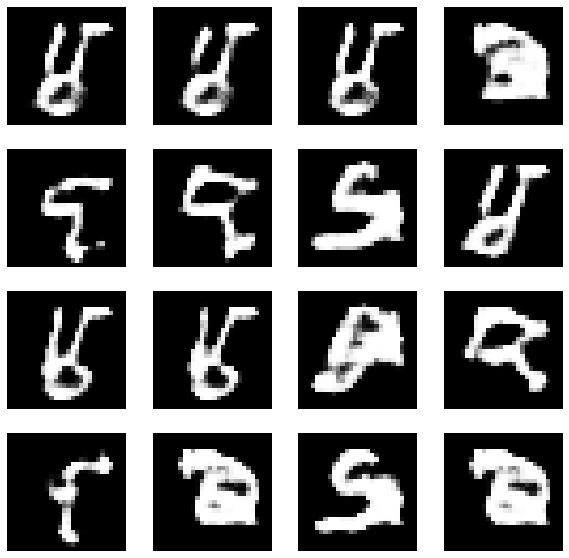

20000: [discriminator loss: 0.6811306476593018, acc: 0.2265625] [gan loss: 2.406158, acc: 0.000000]
20001: [discriminator loss: 0.48603713512420654, acc: 0.4765625] [gan loss: 1.395030, acc: 0.109375]
20002: [discriminator loss: 0.5581709146499634, acc: 0.359375] [gan loss: 1.667534, acc: 0.078125]
20003: [discriminator loss: 0.45678383111953735, acc: 0.4296875] [gan loss: 1.437399, acc: 0.078125]
20004: [discriminator loss: 0.5651863813400269, acc: 0.3984375] [gan loss: 1.415918, acc: 0.093750]
20005: [discriminator loss: 0.6213268041610718, acc: 0.3984375] [gan loss: 1.266491, acc: 0.015625]
20006: [discriminator loss: 0.558030903339386, acc: 0.3359375] [gan loss: 1.680632, acc: 0.000000]
20007: [discriminator loss: 0.5838320851325989, acc: 0.46875] [gan loss: 0.978344, acc: 0.250000]
20008: [discriminator loss: 0.6231441497802734, acc: 0.296875] [gan loss: 1.612030, acc: 0.015625]
20009: [discriminator loss: 0.6352816820144653, acc: 0.453125] [gan loss: 0.790601, acc: 0.390625]
2001

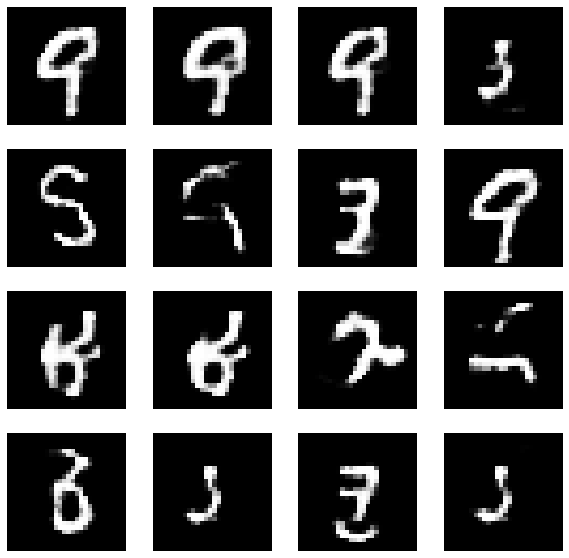

20500: [discriminator loss: 0.5359004139900208, acc: 0.5] [gan loss: 0.972713, acc: 0.421875]
20501: [discriminator loss: 0.5723968744277954, acc: 0.265625] [gan loss: 1.669210, acc: 0.015625]
20502: [discriminator loss: 0.5395720601081848, acc: 0.4765625] [gan loss: 1.263710, acc: 0.125000]
20503: [discriminator loss: 0.5583852529525757, acc: 0.3203125] [gan loss: 1.459557, acc: 0.015625]
20504: [discriminator loss: 0.5170218348503113, acc: 0.4375] [gan loss: 1.145037, acc: 0.125000]
20505: [discriminator loss: 0.5560877919197083, acc: 0.3203125] [gan loss: 1.696254, acc: 0.046875]
20506: [discriminator loss: 0.5018879771232605, acc: 0.4765625] [gan loss: 1.223482, acc: 0.171875]
20507: [discriminator loss: 0.5796558260917664, acc: 0.3046875] [gan loss: 1.789759, acc: 0.000000]
20508: [discriminator loss: 0.4738405644893646, acc: 0.5] [gan loss: 1.181184, acc: 0.109375]
20509: [discriminator loss: 0.5326614379882812, acc: 0.4140625] [gan loss: 1.616276, acc: 0.015625]
20510: [discrimi

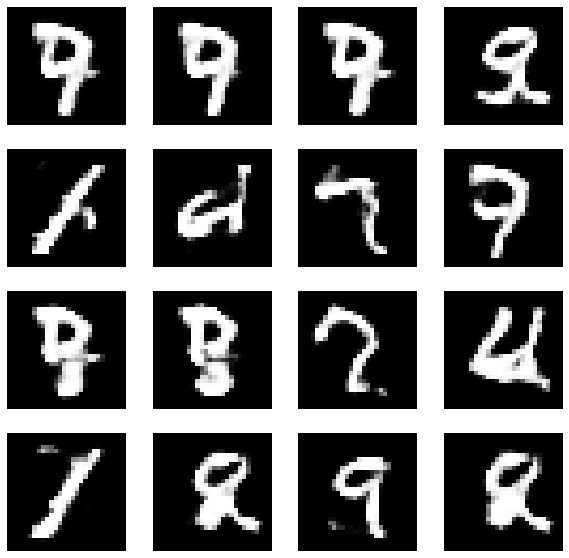

21000: [discriminator loss: 0.6510729789733887, acc: 0.453125] [gan loss: 0.996740, acc: 0.187500]
21001: [discriminator loss: 0.6562190055847168, acc: 0.2890625] [gan loss: 1.431109, acc: 0.078125]
21002: [discriminator loss: 0.6195311546325684, acc: 0.4296875] [gan loss: 0.934965, acc: 0.296875]
21003: [discriminator loss: 0.715996265411377, acc: 0.203125] [gan loss: 1.500340, acc: 0.000000]
21004: [discriminator loss: 0.6794981956481934, acc: 0.484375] [gan loss: 0.741143, acc: 0.500000]
21005: [discriminator loss: 0.697441816329956, acc: 0.1875] [gan loss: 2.039922, acc: 0.000000]
21006: [discriminator loss: 0.5971906781196594, acc: 0.5] [gan loss: 0.573482, acc: 0.750000]
21007: [discriminator loss: 0.7841997146606445, acc: 0.0546875] [gan loss: 1.964386, acc: 0.000000]
21008: [discriminator loss: 0.6650941967964172, acc: 0.5] [gan loss: 0.669149, acc: 0.500000]
21009: [discriminator loss: 0.7549268007278442, acc: 0.0859375] [gan loss: 1.579333, acc: 0.015625]
21010: [discriminato

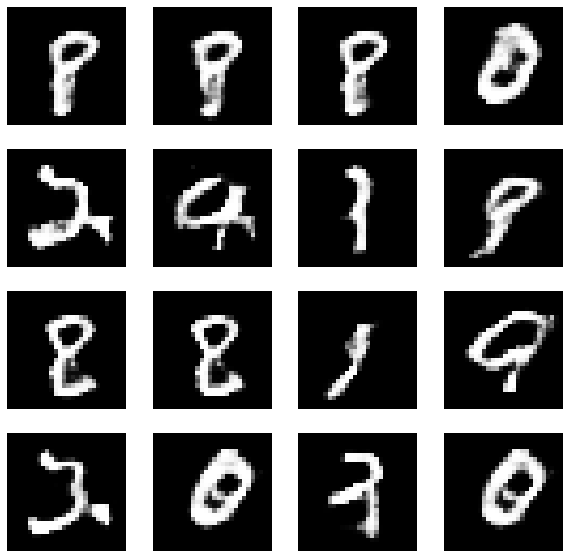

21500: [discriminator loss: 0.6730070114135742, acc: 0.25] [gan loss: 1.277919, acc: 0.078125]
21501: [discriminator loss: 0.6377151608467102, acc: 0.421875] [gan loss: 0.817792, acc: 0.484375]
21502: [discriminator loss: 0.6801252961158752, acc: 0.1875] [gan loss: 1.457791, acc: 0.000000]
21503: [discriminator loss: 0.6558787226676941, acc: 0.4453125] [gan loss: 0.743141, acc: 0.406250]
21504: [discriminator loss: 0.7360050082206726, acc: 0.125] [gan loss: 1.583806, acc: 0.000000]
21505: [discriminator loss: 0.6683826446533203, acc: 0.5] [gan loss: 0.658247, acc: 0.609375]
21506: [discriminator loss: 0.7128559350967407, acc: 0.109375] [gan loss: 1.830457, acc: 0.000000]
21507: [discriminator loss: 0.7318435311317444, acc: 0.4921875] [gan loss: 0.515639, acc: 0.828125]
21508: [discriminator loss: 0.742119312286377, acc: 0.0859375] [gan loss: 1.458390, acc: 0.000000]
21509: [discriminator loss: 0.6574468612670898, acc: 0.4765625] [gan loss: 0.733477, acc: 0.453125]
21510: [discriminator

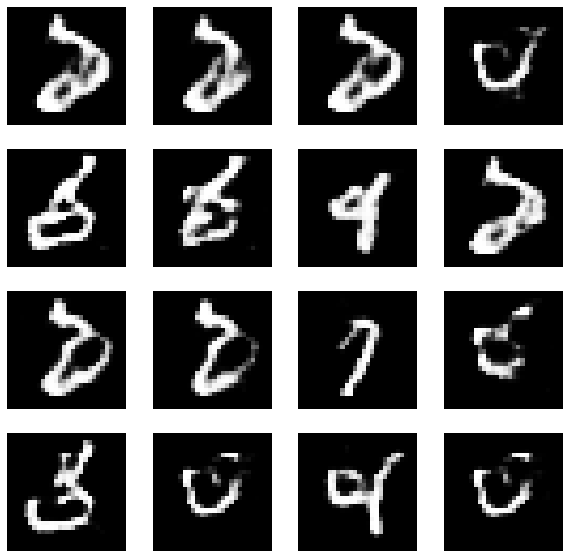

22000: [discriminator loss: 0.6413624882698059, acc: 0.25] [gan loss: 1.323216, acc: 0.000000]
22001: [discriminator loss: 0.5500773191452026, acc: 0.453125] [gan loss: 0.783295, acc: 0.437500]
22002: [discriminator loss: 0.6123303174972534, acc: 0.28125] [gan loss: 1.607853, acc: 0.000000]
22003: [discriminator loss: 0.6516881585121155, acc: 0.4765625] [gan loss: 0.543344, acc: 0.828125]
22004: [discriminator loss: 0.8037052154541016, acc: 0.0625] [gan loss: 1.893650, acc: 0.000000]
22005: [discriminator loss: 0.7117209434509277, acc: 0.5] [gan loss: 0.606763, acc: 0.687500]
22006: [discriminator loss: 0.7330836057662964, acc: 0.1328125] [gan loss: 1.484686, acc: 0.000000]
22007: [discriminator loss: 0.6467685103416443, acc: 0.4609375] [gan loss: 0.830360, acc: 0.453125]
22008: [discriminator loss: 0.6753036975860596, acc: 0.2265625] [gan loss: 1.390042, acc: 0.000000]
22009: [discriminator loss: 0.5582414865493774, acc: 0.46875] [gan loss: 0.982710, acc: 0.203125]
22010: [discriminat

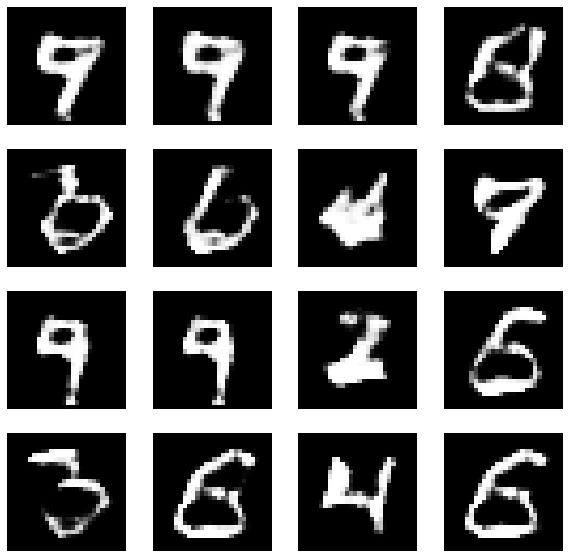

22500: [discriminator loss: 0.7004274725914001, acc: 0.140625] [gan loss: 2.271099, acc: 0.000000]
22501: [discriminator loss: 0.6079774498939514, acc: 0.5] [gan loss: 0.336346, acc: 0.953125]
22502: [discriminator loss: 0.7629004120826721, acc: 0.078125] [gan loss: 1.986986, acc: 0.000000]
22503: [discriminator loss: 0.5820397734642029, acc: 0.5] [gan loss: 0.481671, acc: 0.750000]
22504: [discriminator loss: 0.5840380787849426, acc: 0.2578125] [gan loss: 1.486945, acc: 0.015625]
22505: [discriminator loss: 0.5021203756332397, acc: 0.4921875] [gan loss: 0.984386, acc: 0.218750]
22506: [discriminator loss: 0.49861469864845276, acc: 0.4375] [gan loss: 1.121448, acc: 0.109375]
22507: [discriminator loss: 0.5283809900283813, acc: 0.4609375] [gan loss: 1.224156, acc: 0.078125]
22508: [discriminator loss: 0.5074724555015564, acc: 0.4453125] [gan loss: 1.515810, acc: 0.000000]
22509: [discriminator loss: 0.4837729334831238, acc: 0.5] [gan loss: 1.010671, acc: 0.171875]
22510: [discriminator 

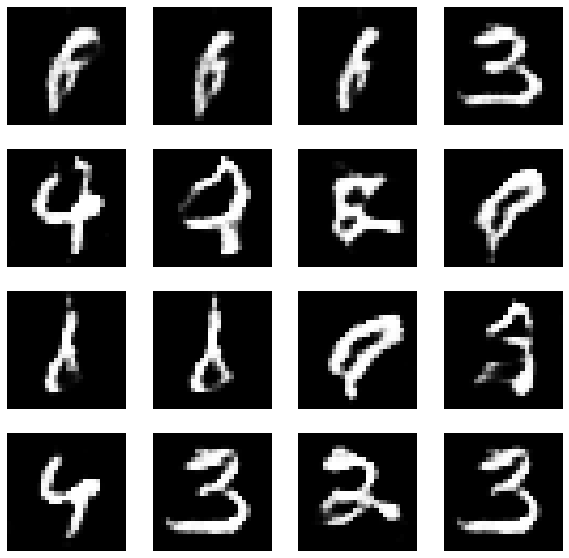

23000: [discriminator loss: 0.6964393258094788, acc: 0.34375] [gan loss: 0.714016, acc: 0.515625]
23001: [discriminator loss: 0.7476900815963745, acc: 0.2890625] [gan loss: 0.867299, acc: 0.250000]
23002: [discriminator loss: 0.6251329779624939, acc: 0.3828125] [gan loss: 0.873885, acc: 0.187500]
23003: [discriminator loss: 0.6292746663093567, acc: 0.3828125] [gan loss: 0.913761, acc: 0.140625]
23004: [discriminator loss: 0.6251871585845947, acc: 0.40625] [gan loss: 0.803446, acc: 0.359375]
23005: [discriminator loss: 0.646729052066803, acc: 0.3125] [gan loss: 1.171926, acc: 0.031250]
23006: [discriminator loss: 0.6323561072349548, acc: 0.4375] [gan loss: 0.811664, acc: 0.453125]
23007: [discriminator loss: 0.5842431783676147, acc: 0.34375] [gan loss: 1.242692, acc: 0.046875]
23008: [discriminator loss: 0.6623563170433044, acc: 0.4296875] [gan loss: 0.659505, acc: 0.578125]
23009: [discriminator loss: 0.687673807144165, acc: 0.1796875] [gan loss: 1.767250, acc: 0.000000]
23010: [discri

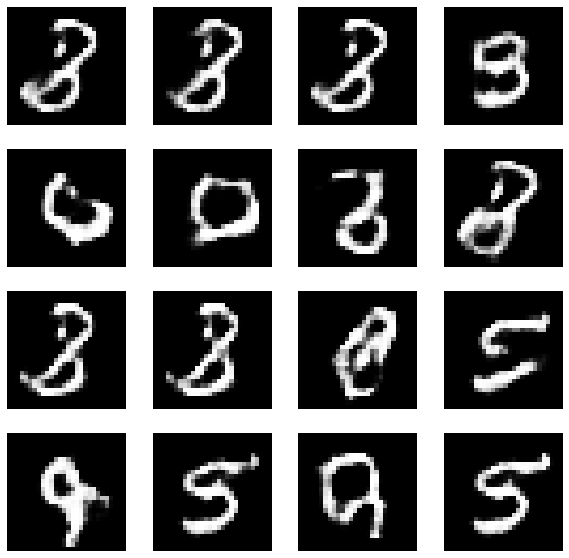

23500: [discriminator loss: 0.7405710220336914, acc: 0.1328125] [gan loss: 1.633055, acc: 0.000000]
23501: [discriminator loss: 0.6485723853111267, acc: 0.4765625] [gan loss: 0.867721, acc: 0.390625]
23502: [discriminator loss: 0.7058814764022827, acc: 0.203125] [gan loss: 1.678614, acc: 0.000000]
23503: [discriminator loss: 0.6918747425079346, acc: 0.4140625] [gan loss: 0.860961, acc: 0.328125]
23504: [discriminator loss: 0.7210071086883545, acc: 0.203125] [gan loss: 1.746799, acc: 0.000000]
23505: [discriminator loss: 0.7173824310302734, acc: 0.4453125] [gan loss: 0.579459, acc: 0.734375]
23506: [discriminator loss: 0.8477728366851807, acc: 0.078125] [gan loss: 1.790245, acc: 0.000000]
23507: [discriminator loss: 0.6733927130699158, acc: 0.4921875] [gan loss: 0.613637, acc: 0.687500]
23508: [discriminator loss: 0.7411921620368958, acc: 0.109375] [gan loss: 1.518967, acc: 0.015625]
23509: [discriminator loss: 0.6479642391204834, acc: 0.4453125] [gan loss: 0.887661, acc: 0.312500]
2351

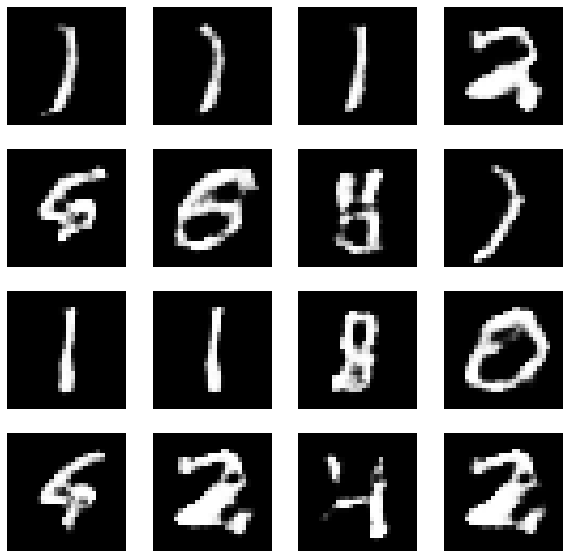

24000: [discriminator loss: 0.6661472320556641, acc: 0.484375] [gan loss: 0.486831, acc: 0.812500]
24001: [discriminator loss: 0.6520196199417114, acc: 0.1875] [gan loss: 1.288736, acc: 0.031250]
24002: [discriminator loss: 0.619513988494873, acc: 0.4765625] [gan loss: 0.611618, acc: 0.625000]
24003: [discriminator loss: 0.7213414311408997, acc: 0.171875] [gan loss: 1.561691, acc: 0.000000]
24004: [discriminator loss: 0.6515453457832336, acc: 0.4921875] [gan loss: 0.453081, acc: 0.890625]
24005: [discriminator loss: 0.7814456224441528, acc: 0.0859375] [gan loss: 1.802513, acc: 0.015625]
24006: [discriminator loss: 0.652871310710907, acc: 0.5] [gan loss: 0.371762, acc: 0.875000]
24007: [discriminator loss: 0.7393496036529541, acc: 0.140625] [gan loss: 1.408663, acc: 0.015625]
24008: [discriminator loss: 0.651260495185852, acc: 0.453125] [gan loss: 0.628557, acc: 0.734375]
24009: [discriminator loss: 0.7024232745170593, acc: 0.1953125] [gan loss: 1.490503, acc: 0.093750]
24010: [discrimi

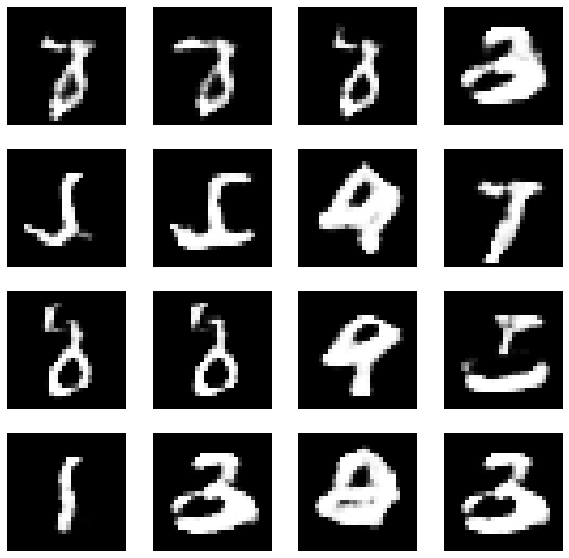

24500: [discriminator loss: 0.6473177671432495, acc: 0.3359375] [gan loss: 1.572204, acc: 0.062500]
24501: [discriminator loss: 0.5624508261680603, acc: 0.4765625] [gan loss: 0.593191, acc: 0.687500]
24502: [discriminator loss: 0.6300039887428284, acc: 0.2109375] [gan loss: 2.196145, acc: 0.062500]
24503: [discriminator loss: 0.6555156707763672, acc: 0.4921875] [gan loss: 0.450474, acc: 0.890625]
24504: [discriminator loss: 0.7010874152183533, acc: 0.171875] [gan loss: 2.559670, acc: 0.000000]
24505: [discriminator loss: 0.7376221418380737, acc: 0.5] [gan loss: 0.324938, acc: 0.984375]
24506: [discriminator loss: 0.8668588399887085, acc: 0.078125] [gan loss: 2.667025, acc: 0.000000]
24507: [discriminator loss: 0.5999633073806763, acc: 0.5] [gan loss: 0.695601, acc: 0.484375]
24508: [discriminator loss: 0.6575496196746826, acc: 0.1640625] [gan loss: 2.996468, acc: 0.000000]
24509: [discriminator loss: 0.6603498458862305, acc: 0.5] [gan loss: 0.624853, acc: 0.609375]
24510: [discriminato

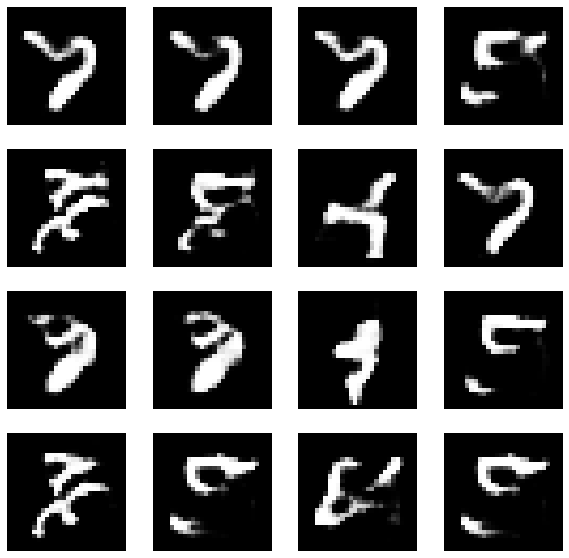

25000: [discriminator loss: 0.44540491700172424, acc: 0.4921875] [gan loss: 1.164937, acc: 0.031250]
25001: [discriminator loss: 0.4946227967739105, acc: 0.359375] [gan loss: 2.192302, acc: 0.000000]
25002: [discriminator loss: 0.4361913204193115, acc: 0.5] [gan loss: 0.747610, acc: 0.515625]
25003: [discriminator loss: 0.5582080483436584, acc: 0.2421875] [gan loss: 1.887440, acc: 0.000000]
25004: [discriminator loss: 0.4462721645832062, acc: 0.5] [gan loss: 0.845918, acc: 0.468750]
25005: [discriminator loss: 0.5676150321960449, acc: 0.2734375] [gan loss: 1.713302, acc: 0.000000]
25006: [discriminator loss: 0.5149115324020386, acc: 0.4921875] [gan loss: 0.834712, acc: 0.453125]
25007: [discriminator loss: 0.5304652452468872, acc: 0.296875] [gan loss: 1.662704, acc: 0.015625]
25008: [discriminator loss: 0.49927276372909546, acc: 0.5] [gan loss: 0.704597, acc: 0.531250]
25009: [discriminator loss: 0.5509817600250244, acc: 0.3046875] [gan loss: 1.668882, acc: 0.015625]
25010: [discrimina

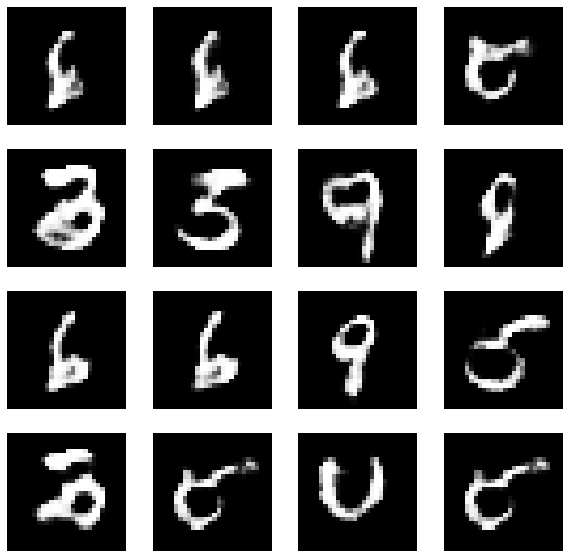

25500: [discriminator loss: 0.5619562864303589, acc: 0.2734375] [gan loss: 0.821422, acc: 0.468750]
25501: [discriminator loss: 0.4897569417953491, acc: 0.5] [gan loss: 0.219000, acc: 1.000000]
25502: [discriminator loss: 0.5500864386558533, acc: 0.296875] [gan loss: 0.950426, acc: 0.421875]
25503: [discriminator loss: 0.6655711531639099, acc: 0.4375] [gan loss: 0.327218, acc: 0.984375]
25504: [discriminator loss: 0.6706860065460205, acc: 0.265625] [gan loss: 1.987732, acc: 0.015625]
25505: [discriminator loss: 0.6918862462043762, acc: 0.5] [gan loss: 0.049864, acc: 1.000000]
25506: [discriminator loss: 0.8978520631790161, acc: 0.03125] [gan loss: 1.886982, acc: 0.015625]
25507: [discriminator loss: 0.7231529355049133, acc: 0.4453125] [gan loss: 0.842858, acc: 0.437500]
25508: [discriminator loss: 0.6664199233055115, acc: 0.3125] [gan loss: 1.537490, acc: 0.093750]
25509: [discriminator loss: 0.625427782535553, acc: 0.4296875] [gan loss: 0.983291, acc: 0.265625]
25510: [discriminator l

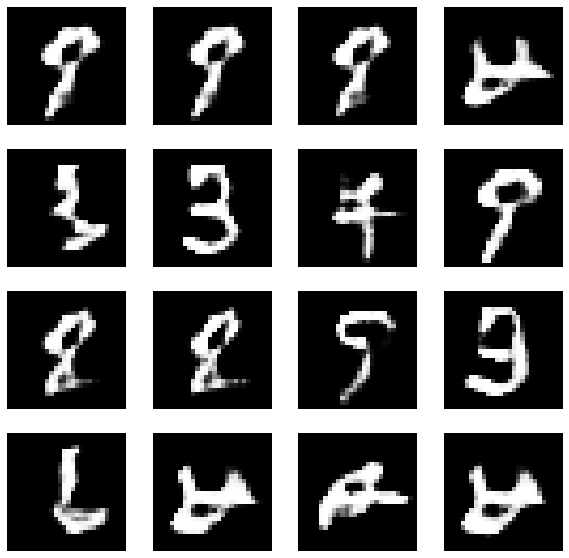

26000: [discriminator loss: 0.5900766849517822, acc: 0.46875] [gan loss: 0.674205, acc: 0.453125]
26001: [discriminator loss: 0.6902643442153931, acc: 0.21875] [gan loss: 1.818406, acc: 0.015625]
26002: [discriminator loss: 0.5748938322067261, acc: 0.484375] [gan loss: 0.845184, acc: 0.265625]
26003: [discriminator loss: 0.6722626686096191, acc: 0.203125] [gan loss: 1.988220, acc: 0.000000]
26004: [discriminator loss: 0.6337454319000244, acc: 0.5] [gan loss: 0.550952, acc: 0.718750]
26005: [discriminator loss: 0.6921297907829285, acc: 0.140625] [gan loss: 1.993283, acc: 0.000000]
26006: [discriminator loss: 0.5811724066734314, acc: 0.5] [gan loss: 0.696466, acc: 0.671875]
26007: [discriminator loss: 0.6154648065567017, acc: 0.203125] [gan loss: 1.744295, acc: 0.000000]
26008: [discriminator loss: 0.5412092208862305, acc: 0.5] [gan loss: 0.829694, acc: 0.328125]
26009: [discriminator loss: 0.5669650435447693, acc: 0.359375] [gan loss: 1.399758, acc: 0.000000]
26010: [discriminator loss:

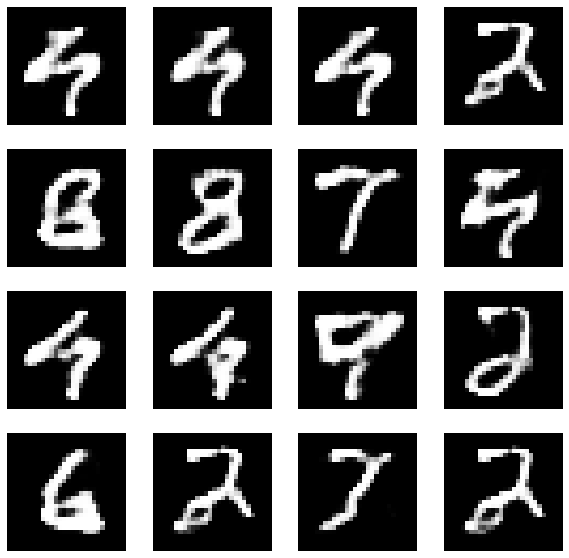

26500: [discriminator loss: 0.7870502471923828, acc: 0.0625] [gan loss: 2.679739, acc: 0.000000]
26501: [discriminator loss: 0.8135892748832703, acc: 0.5] [gan loss: 0.621024, acc: 0.546875]
26502: [discriminator loss: 0.7653972506523132, acc: 0.1875] [gan loss: 2.429262, acc: 0.000000]
26503: [discriminator loss: 0.7154605388641357, acc: 0.5] [gan loss: 0.747204, acc: 0.437500]
26504: [discriminator loss: 0.7165522575378418, acc: 0.234375] [gan loss: 2.040445, acc: 0.000000]
26505: [discriminator loss: 0.6699666976928711, acc: 0.4609375] [gan loss: 0.828846, acc: 0.406250]
26506: [discriminator loss: 0.703224778175354, acc: 0.3046875] [gan loss: 1.658219, acc: 0.000000]
26507: [discriminator loss: 0.6043111085891724, acc: 0.4453125] [gan loss: 0.984385, acc: 0.250000]
26508: [discriminator loss: 0.6048393249511719, acc: 0.2890625] [gan loss: 1.846268, acc: 0.000000]
26509: [discriminator loss: 0.6951979994773865, acc: 0.4453125] [gan loss: 0.912674, acc: 0.187500]
26510: [discriminato

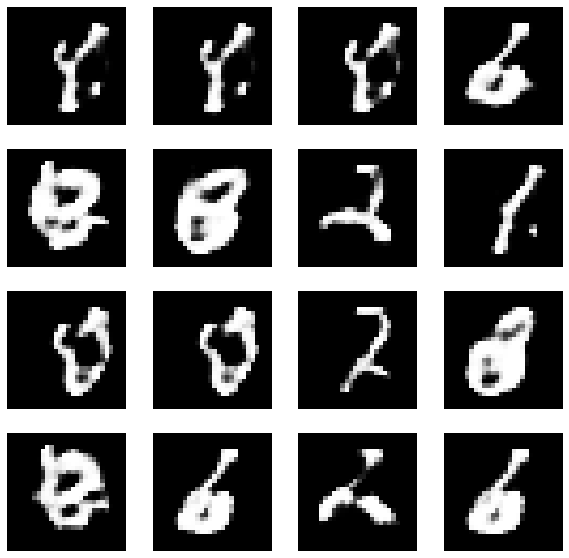

27000: [discriminator loss: 0.5301273465156555, acc: 0.4296875] [gan loss: 1.174576, acc: 0.218750]
27001: [discriminator loss: 0.46908998489379883, acc: 0.5] [gan loss: 0.512126, acc: 0.828125]
27002: [discriminator loss: 0.598224937915802, acc: 0.3359375] [gan loss: 2.035945, acc: 0.078125]
27003: [discriminator loss: 0.510890781879425, acc: 0.5] [gan loss: 0.234040, acc: 0.984375]
27004: [discriminator loss: 0.694591760635376, acc: 0.125] [gan loss: 3.053405, acc: 0.000000]
27005: [discriminator loss: 0.5811220407485962, acc: 0.5] [gan loss: 0.563287, acc: 0.765625]
27006: [discriminator loss: 0.6196107864379883, acc: 0.2421875] [gan loss: 2.105251, acc: 0.015625]
27007: [discriminator loss: 0.5427904725074768, acc: 0.4296875] [gan loss: 1.400985, acc: 0.062500]
27008: [discriminator loss: 0.5793536305427551, acc: 0.390625] [gan loss: 1.870592, acc: 0.015625]
27009: [discriminator loss: 0.6022993922233582, acc: 0.4375] [gan loss: 0.997788, acc: 0.296875]
27010: [discriminator loss: 

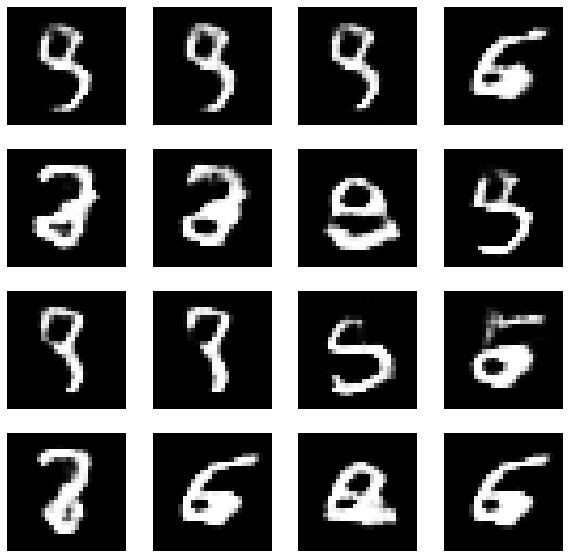

27500: [discriminator loss: 0.49043434858322144, acc: 0.40625] [gan loss: 1.694691, acc: 0.000000]
27501: [discriminator loss: 0.584346354007721, acc: 0.484375] [gan loss: 0.694066, acc: 0.546875]
27502: [discriminator loss: 0.5843069553375244, acc: 0.3203125] [gan loss: 1.894912, acc: 0.031250]
27503: [discriminator loss: 0.5228659510612488, acc: 0.4921875] [gan loss: 0.892145, acc: 0.281250]
27504: [discriminator loss: 0.5043153166770935, acc: 0.40625] [gan loss: 1.759190, acc: 0.046875]
27505: [discriminator loss: 0.5854856967926025, acc: 0.4765625] [gan loss: 1.058474, acc: 0.187500]
27506: [discriminator loss: 0.6077656745910645, acc: 0.3125] [gan loss: 2.207741, acc: 0.000000]
27507: [discriminator loss: 0.5151869058609009, acc: 0.4765625] [gan loss: 0.964416, acc: 0.203125]
27508: [discriminator loss: 0.5729901790618896, acc: 0.3359375] [gan loss: 1.955261, acc: 0.000000]
27509: [discriminator loss: 0.5414811372756958, acc: 0.5] [gan loss: 0.829631, acc: 0.359375]
27510: [discri

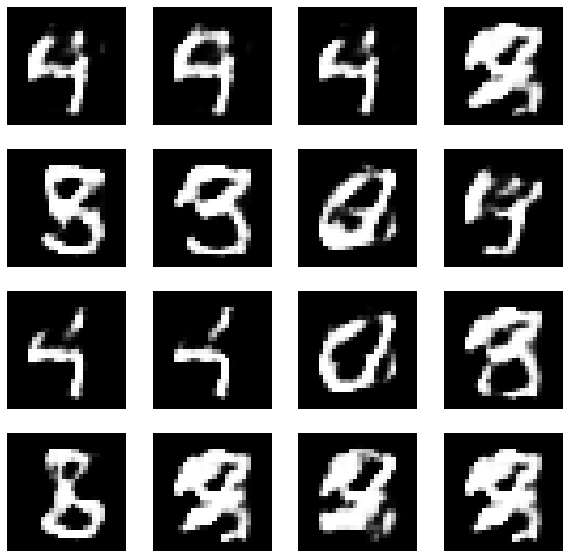

28000: [discriminator loss: 0.4973674714565277, acc: 0.5] [gan loss: 0.302350, acc: 0.890625]
28001: [discriminator loss: 0.5758482217788696, acc: 0.296875] [gan loss: 1.449397, acc: 0.015625]
28002: [discriminator loss: 0.38570451736450195, acc: 0.5] [gan loss: 0.364637, acc: 0.875000]
28003: [discriminator loss: 0.5493526458740234, acc: 0.3125] [gan loss: 1.272107, acc: 0.062500]
28004: [discriminator loss: 0.5027925372123718, acc: 0.5] [gan loss: 0.250080, acc: 0.937500]
28005: [discriminator loss: 0.4771055281162262, acc: 0.375] [gan loss: 0.840956, acc: 0.468750]
28006: [discriminator loss: 0.3869549036026001, acc: 0.5] [gan loss: 0.404611, acc: 0.812500]
28007: [discriminator loss: 0.4630157947540283, acc: 0.421875] [gan loss: 0.867776, acc: 0.375000]
28008: [discriminator loss: 0.5185569524765015, acc: 0.453125] [gan loss: 0.347779, acc: 0.843750]
28009: [discriminator loss: 0.34960299730300903, acc: 0.484375] [gan loss: 0.581490, acc: 0.656250]
28010: [discriminator loss: 0.491

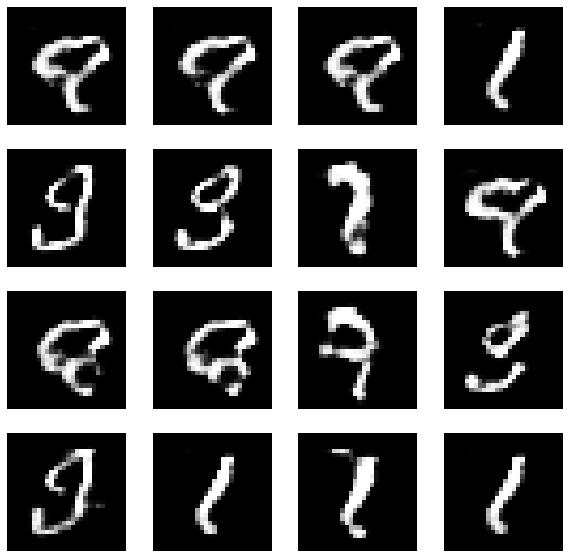

28500: [discriminator loss: 0.599693775177002, acc: 0.5] [gan loss: 0.912426, acc: 0.296875]
28501: [discriminator loss: 0.6350955963134766, acc: 0.1875] [gan loss: 2.869618, acc: 0.000000]
28502: [discriminator loss: 0.5644674301147461, acc: 0.5] [gan loss: 0.784136, acc: 0.375000]
28503: [discriminator loss: 0.6515188217163086, acc: 0.171875] [gan loss: 2.453367, acc: 0.000000]
28504: [discriminator loss: 0.5556596517562866, acc: 0.4921875] [gan loss: 1.128741, acc: 0.109375]
28505: [discriminator loss: 0.5647105574607849, acc: 0.359375] [gan loss: 1.777380, acc: 0.000000]
28506: [discriminator loss: 0.6120190620422363, acc: 0.4453125] [gan loss: 1.020992, acc: 0.125000]
28507: [discriminator loss: 0.6664531230926514, acc: 0.25] [gan loss: 2.091506, acc: 0.000000]
28508: [discriminator loss: 0.5499464273452759, acc: 0.4921875] [gan loss: 0.778135, acc: 0.515625]
28509: [discriminator loss: 0.6589112877845764, acc: 0.25] [gan loss: 2.326185, acc: 0.000000]
28510: [discriminator loss: 

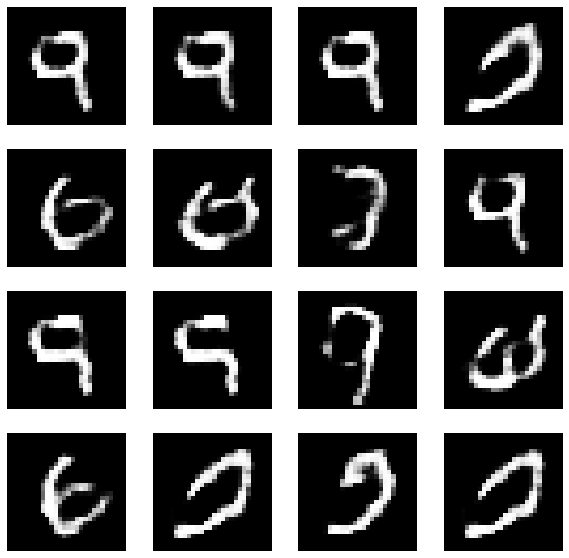

29000: [discriminator loss: 0.6406425833702087, acc: 0.5] [gan loss: 0.811727, acc: 0.390625]
29001: [discriminator loss: 0.6665166616439819, acc: 0.1796875] [gan loss: 1.687996, acc: 0.000000]
29002: [discriminator loss: 0.6502395272254944, acc: 0.5] [gan loss: 0.482314, acc: 0.812500]
29003: [discriminator loss: 0.7374791502952576, acc: 0.0859375] [gan loss: 1.818747, acc: 0.000000]
29004: [discriminator loss: 0.6363067030906677, acc: 0.5] [gan loss: 0.556104, acc: 0.812500]
29005: [discriminator loss: 0.6643309593200684, acc: 0.1796875] [gan loss: 1.513688, acc: 0.000000]
29006: [discriminator loss: 0.6975286602973938, acc: 0.4921875] [gan loss: 0.818939, acc: 0.484375]
29007: [discriminator loss: 0.6709931492805481, acc: 0.1875] [gan loss: 1.688666, acc: 0.000000]
29008: [discriminator loss: 0.6066654920578003, acc: 0.484375] [gan loss: 0.812063, acc: 0.406250]
29009: [discriminator loss: 0.6823846697807312, acc: 0.2109375] [gan loss: 1.452773, acc: 0.015625]
29010: [discriminator 

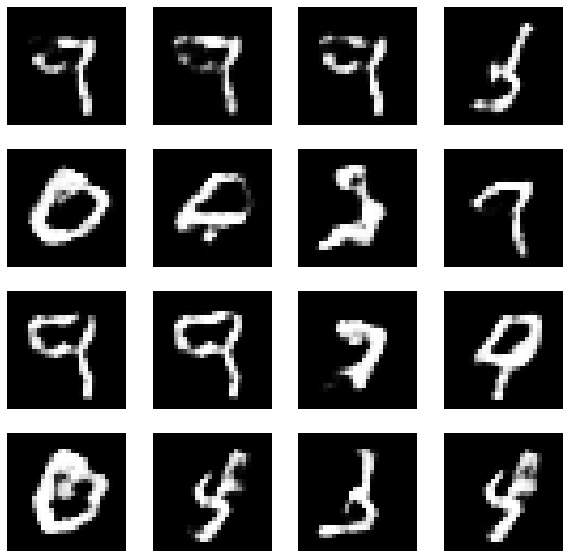

29500: [discriminator loss: 0.7241392135620117, acc: 0.4765625] [gan loss: 0.632227, acc: 0.687500]
29501: [discriminator loss: 0.7585153579711914, acc: 0.1171875] [gan loss: 1.722369, acc: 0.015625]
29502: [discriminator loss: 0.7488611340522766, acc: 0.3984375] [gan loss: 0.716288, acc: 0.546875]
29503: [discriminator loss: 0.6825079917907715, acc: 0.25] [gan loss: 1.603730, acc: 0.000000]
29504: [discriminator loss: 0.7771250605583191, acc: 0.4140625] [gan loss: 0.631504, acc: 0.593750]
29505: [discriminator loss: 0.7468336820602417, acc: 0.1484375] [gan loss: 1.564023, acc: 0.015625]
29506: [discriminator loss: 0.7277958989143372, acc: 0.3984375] [gan loss: 0.778971, acc: 0.546875]
29507: [discriminator loss: 0.7548032999038696, acc: 0.15625] [gan loss: 1.649231, acc: 0.015625]
29508: [discriminator loss: 0.7060292363166809, acc: 0.4453125] [gan loss: 0.761220, acc: 0.468750]
29509: [discriminator loss: 0.7310972809791565, acc: 0.203125] [gan loss: 1.563566, acc: 0.031250]
29510: [

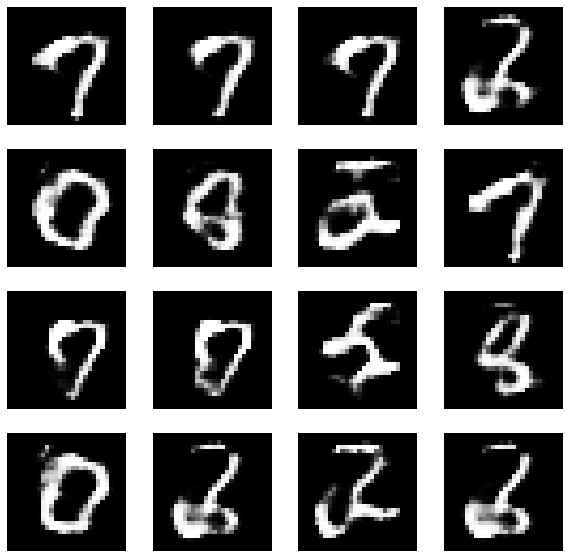

30000: [discriminator loss: 0.6395589709281921, acc: 0.203125] [gan loss: 1.658831, acc: 0.078125]
30001: [discriminator loss: 0.850911021232605, acc: 0.46875] [gan loss: 0.477572, acc: 0.828125]
30002: [discriminator loss: 0.7360786199569702, acc: 0.1875] [gan loss: 1.317833, acc: 0.187500]
30003: [discriminator loss: 0.683968186378479, acc: 0.4765625] [gan loss: 0.496438, acc: 0.750000]
30004: [discriminator loss: 0.7799901962280273, acc: 0.1328125] [gan loss: 1.785537, acc: 0.031250]
30005: [discriminator loss: 0.6951998472213745, acc: 0.484375] [gan loss: 0.527322, acc: 0.734375]
30006: [discriminator loss: 0.7822553515434265, acc: 0.125] [gan loss: 1.516682, acc: 0.093750]
30007: [discriminator loss: 0.6876094341278076, acc: 0.4765625] [gan loss: 0.511788, acc: 0.765625]
30008: [discriminator loss: 0.7401899099349976, acc: 0.1953125] [gan loss: 1.244361, acc: 0.171875]
30009: [discriminator loss: 0.6123629212379456, acc: 0.4296875] [gan loss: 0.706590, acc: 0.640625]
30010: [discr

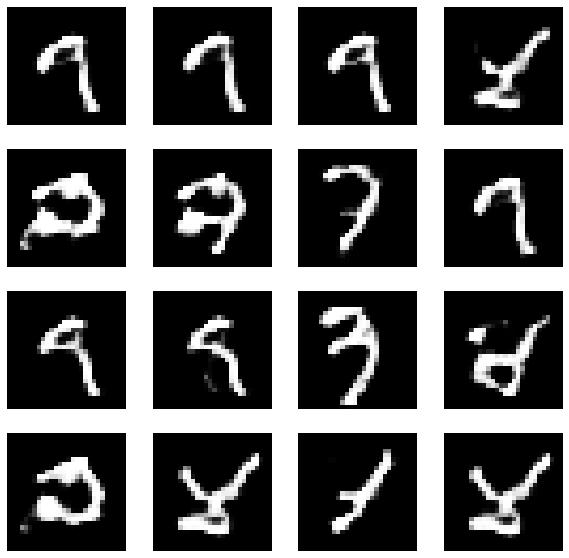

30500: [discriminator loss: 0.5954993367195129, acc: 0.3828125] [gan loss: 1.856131, acc: 0.000000]
30501: [discriminator loss: 0.550849199295044, acc: 0.4765625] [gan loss: 0.893476, acc: 0.250000]
30502: [discriminator loss: 0.5888464450836182, acc: 0.3046875] [gan loss: 2.002897, acc: 0.000000]
30503: [discriminator loss: 0.5044670104980469, acc: 0.5] [gan loss: 0.440166, acc: 0.875000]
30504: [discriminator loss: 0.6661727428436279, acc: 0.1484375] [gan loss: 2.185118, acc: 0.000000]
30505: [discriminator loss: 0.5267846584320068, acc: 0.5] [gan loss: 0.626869, acc: 0.609375]
30506: [discriminator loss: 0.5739974975585938, acc: 0.3671875] [gan loss: 1.364132, acc: 0.078125]
30507: [discriminator loss: 0.5007017254829407, acc: 0.5] [gan loss: 0.452357, acc: 0.781250]
30508: [discriminator loss: 0.5514438152313232, acc: 0.359375] [gan loss: 1.040367, acc: 0.140625]
30509: [discriminator loss: 0.4908882975578308, acc: 0.484375] [gan loss: 0.377523, acc: 0.906250]
30510: [discriminator

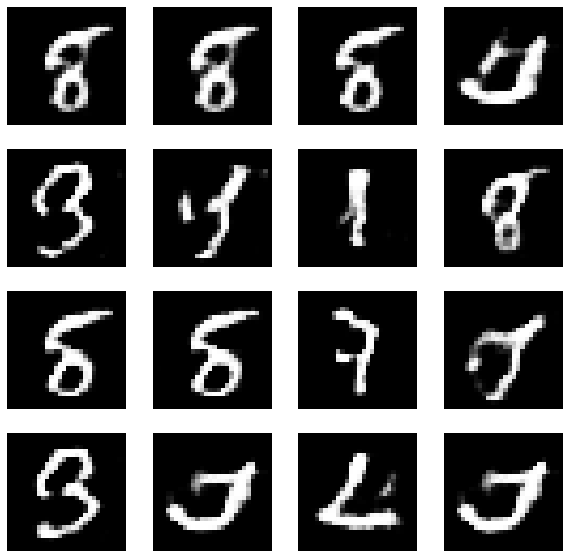

31000: [discriminator loss: 0.568428635597229, acc: 0.375] [gan loss: 1.001021, acc: 0.218750]
31001: [discriminator loss: 0.5511283874511719, acc: 0.4375] [gan loss: 0.967451, acc: 0.328125]
31002: [discriminator loss: 0.6434332728385925, acc: 0.4140625] [gan loss: 0.833382, acc: 0.437500]
31003: [discriminator loss: 0.6070290803909302, acc: 0.359375] [gan loss: 1.368986, acc: 0.000000]
31004: [discriminator loss: 0.5497272610664368, acc: 0.484375] [gan loss: 0.838130, acc: 0.375000]
31005: [discriminator loss: 0.5843162536621094, acc: 0.2421875] [gan loss: 1.944121, acc: 0.000000]
31006: [discriminator loss: 0.6426378488540649, acc: 0.5] [gan loss: 0.579773, acc: 0.750000]
31007: [discriminator loss: 0.7881420254707336, acc: 0.0390625] [gan loss: 2.197776, acc: 0.000000]
31008: [discriminator loss: 0.6683092713356018, acc: 0.5] [gan loss: 0.620200, acc: 0.656250]
31009: [discriminator loss: 0.7432742118835449, acc: 0.078125] [gan loss: 1.696097, acc: 0.000000]
31010: [discriminator l

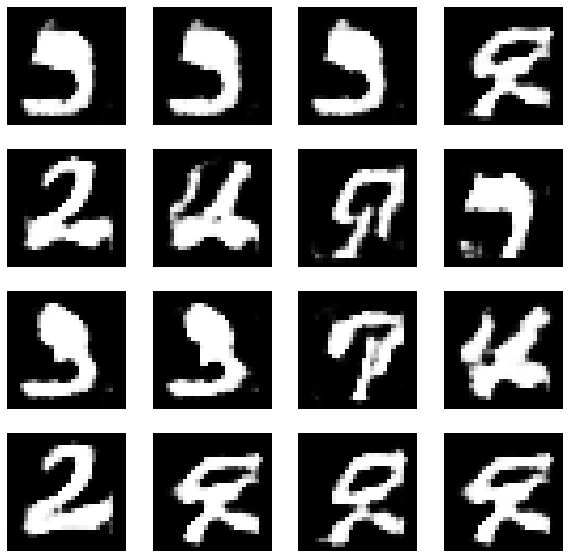

31500: [discriminator loss: 0.29989469051361084, acc: 0.5] [gan loss: 0.156439, acc: 1.000000]
31501: [discriminator loss: 0.3313136398792267, acc: 0.5] [gan loss: 0.422525, acc: 0.781250]
31502: [discriminator loss: 0.3193313777446747, acc: 0.5] [gan loss: 0.100515, acc: 0.984375]
31503: [discriminator loss: 0.3909490406513214, acc: 0.4921875] [gan loss: 0.526126, acc: 0.796875]
31504: [discriminator loss: 0.31922054290771484, acc: 0.5] [gan loss: 0.096264, acc: 1.000000]
31505: [discriminator loss: 0.42852067947387695, acc: 0.46875] [gan loss: 0.921005, acc: 0.421875]
31506: [discriminator loss: 0.45855453610420227, acc: 0.5] [gan loss: 0.092527, acc: 1.000000]
31507: [discriminator loss: 0.4611990451812744, acc: 0.3828125] [gan loss: 1.076803, acc: 0.250000]
31508: [discriminator loss: 0.5050628781318665, acc: 0.5] [gan loss: 0.056989, acc: 1.000000]
31509: [discriminator loss: 0.4277164936065674, acc: 0.375] [gan loss: 0.545863, acc: 0.765625]
31510: [discriminator loss: 0.59901022

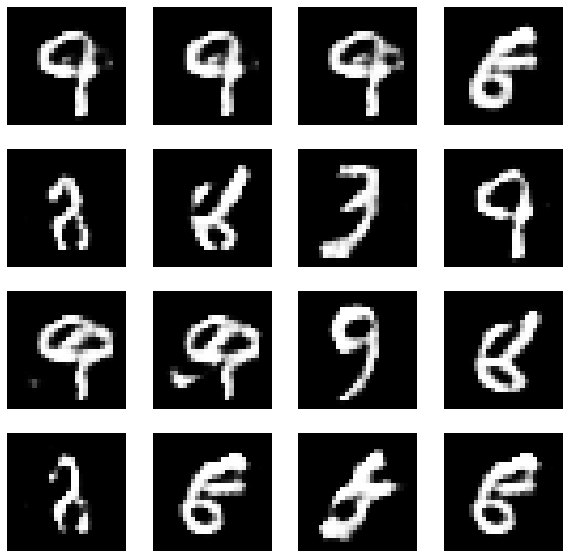

32000: [discriminator loss: 0.5385189652442932, acc: 0.359375] [gan loss: 1.736832, acc: 0.000000]
32001: [discriminator loss: 0.5531925559043884, acc: 0.453125] [gan loss: 1.176051, acc: 0.140625]
32002: [discriminator loss: 0.524699866771698, acc: 0.3671875] [gan loss: 2.091249, acc: 0.000000]
32003: [discriminator loss: 0.5860108733177185, acc: 0.5] [gan loss: 0.840430, acc: 0.468750]
32004: [discriminator loss: 0.6349952220916748, acc: 0.171875] [gan loss: 2.563272, acc: 0.000000]
32005: [discriminator loss: 0.6621878743171692, acc: 0.5] [gan loss: 0.797055, acc: 0.578125]
32006: [discriminator loss: 0.7054988741874695, acc: 0.140625] [gan loss: 2.231845, acc: 0.000000]
32007: [discriminator loss: 0.5803494453430176, acc: 0.5] [gan loss: 1.031741, acc: 0.296875]
32008: [discriminator loss: 0.6544368863105774, acc: 0.21875] [gan loss: 1.831986, acc: 0.000000]
32009: [discriminator loss: 0.601324737071991, acc: 0.5] [gan loss: 0.828022, acc: 0.453125]
32010: [discriminator loss: 0.64

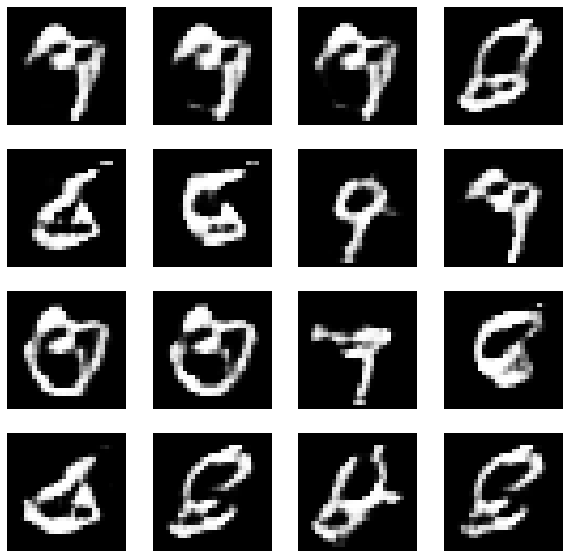

32500: [discriminator loss: 0.5752190351486206, acc: 0.4765625] [gan loss: 0.870350, acc: 0.468750]
32501: [discriminator loss: 0.6683773994445801, acc: 0.1640625] [gan loss: 2.766654, acc: 0.000000]
32502: [discriminator loss: 0.6606532335281372, acc: 0.5] [gan loss: 0.637199, acc: 0.687500]
32503: [discriminator loss: 0.7563520669937134, acc: 0.109375] [gan loss: 2.673285, acc: 0.015625]
32504: [discriminator loss: 0.5644088387489319, acc: 0.5] [gan loss: 1.059719, acc: 0.250000]
32505: [discriminator loss: 0.562218427658081, acc: 0.3515625] [gan loss: 1.900550, acc: 0.000000]
32506: [discriminator loss: 0.5980513095855713, acc: 0.4375] [gan loss: 1.362595, acc: 0.062500]
32507: [discriminator loss: 0.5824980735778809, acc: 0.3671875] [gan loss: 1.484635, acc: 0.000000]
32508: [discriminator loss: 0.5077877044677734, acc: 0.453125] [gan loss: 1.348026, acc: 0.046875]
32509: [discriminator loss: 0.4874764382839203, acc: 0.4375] [gan loss: 1.761817, acc: 0.000000]
32510: [discriminator

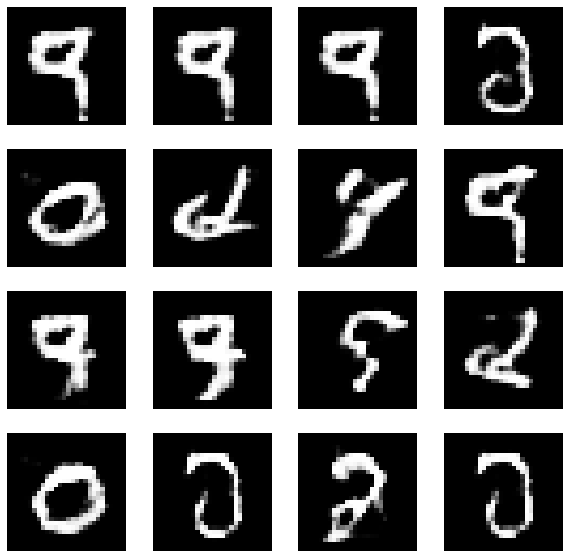

33000: [discriminator loss: 0.6447203755378723, acc: 0.1484375] [gan loss: 1.638999, acc: 0.000000]
33001: [discriminator loss: 0.6283701062202454, acc: 0.484375] [gan loss: 0.895429, acc: 0.421875]
33002: [discriminator loss: 0.627720296382904, acc: 0.234375] [gan loss: 1.679210, acc: 0.015625]
33003: [discriminator loss: 0.6381560564041138, acc: 0.46875] [gan loss: 0.766938, acc: 0.468750]
33004: [discriminator loss: 0.6585144996643066, acc: 0.203125] [gan loss: 1.446754, acc: 0.062500]
33005: [discriminator loss: 0.6750509142875671, acc: 0.4453125] [gan loss: 0.729282, acc: 0.484375]
33006: [discriminator loss: 0.6102087497711182, acc: 0.265625] [gan loss: 1.337554, acc: 0.031250]
33007: [discriminator loss: 0.6291643381118774, acc: 0.484375] [gan loss: 0.744219, acc: 0.484375]
33008: [discriminator loss: 0.6809383630752563, acc: 0.1640625] [gan loss: 1.825913, acc: 0.015625]
33009: [discriminator loss: 0.6586884260177612, acc: 0.4765625] [gan loss: 0.762270, acc: 0.453125]
33010: [

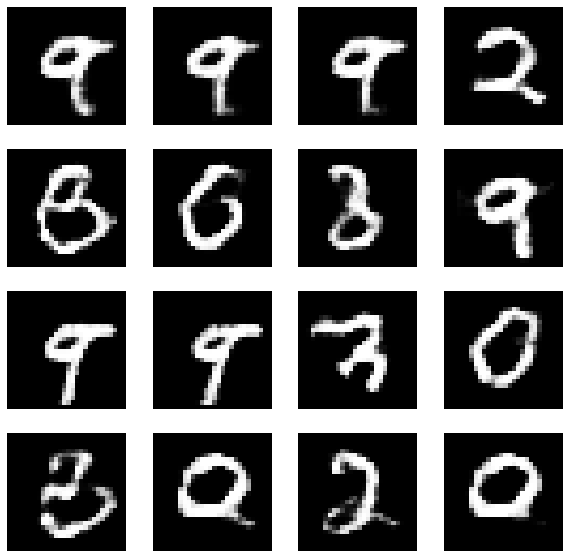

33500: [discriminator loss: 0.7074317336082458, acc: 0.1484375] [gan loss: 1.638768, acc: 0.015625]
33501: [discriminator loss: 0.7184668779373169, acc: 0.4609375] [gan loss: 0.553767, acc: 0.781250]
33502: [discriminator loss: 0.8366334438323975, acc: 0.0625] [gan loss: 1.542493, acc: 0.000000]
33503: [discriminator loss: 0.6858477592468262, acc: 0.5] [gan loss: 0.659700, acc: 0.578125]
33504: [discriminator loss: 0.7813303470611572, acc: 0.109375] [gan loss: 1.638397, acc: 0.000000]
33505: [discriminator loss: 0.6463863849639893, acc: 0.46875] [gan loss: 0.578021, acc: 0.765625]
33506: [discriminator loss: 0.7918704748153687, acc: 0.078125] [gan loss: 1.577027, acc: 0.015625]
33507: [discriminator loss: 0.7315099239349365, acc: 0.3828125] [gan loss: 0.600258, acc: 0.703125]
33508: [discriminator loss: 0.7638775706291199, acc: 0.0703125] [gan loss: 1.535994, acc: 0.000000]
33509: [discriminator loss: 0.6486222743988037, acc: 0.4609375] [gan loss: 0.609689, acc: 0.656250]
33510: [discr

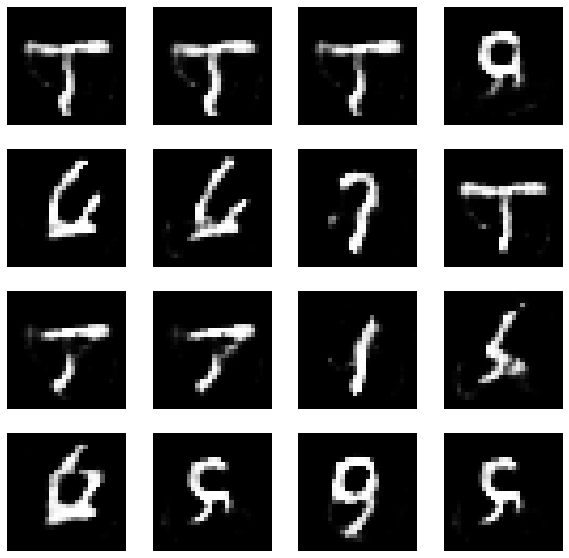

34000: [discriminator loss: 0.6610879898071289, acc: 0.2109375] [gan loss: 2.363822, acc: 0.000000]
34001: [discriminator loss: 0.4948081076145172, acc: 0.5] [gan loss: 0.651905, acc: 0.656250]
34002: [discriminator loss: 0.47598499059677124, acc: 0.3984375] [gan loss: 1.645161, acc: 0.000000]
34003: [discriminator loss: 0.42116233706474304, acc: 0.5] [gan loss: 0.699423, acc: 0.562500]
34004: [discriminator loss: 0.3994925618171692, acc: 0.4453125] [gan loss: 1.195101, acc: 0.109375]
34005: [discriminator loss: 0.35735955834388733, acc: 0.5] [gan loss: 0.772501, acc: 0.468750]
34006: [discriminator loss: 0.43390610814094543, acc: 0.46875] [gan loss: 1.248863, acc: 0.062500]
34007: [discriminator loss: 0.38609716296195984, acc: 0.5] [gan loss: 1.162077, acc: 0.171875]
34008: [discriminator loss: 0.35582900047302246, acc: 0.4765625] [gan loss: 1.101774, acc: 0.187500]
34009: [discriminator loss: 0.37625885009765625, acc: 0.4921875] [gan loss: 1.301043, acc: 0.062500]
34010: [discriminat

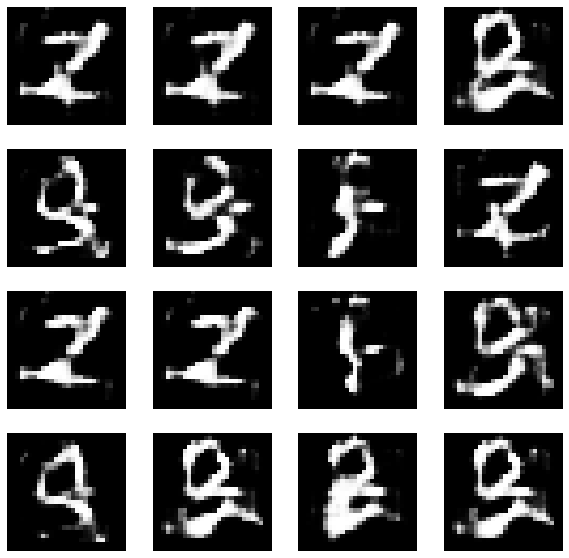

34500: [discriminator loss: 0.2722092270851135, acc: 0.5] [gan loss: 0.293494, acc: 1.000000]
34501: [discriminator loss: 0.2783481478691101, acc: 0.5] [gan loss: 0.078873, acc: 1.000000]
34502: [discriminator loss: 0.27537044882774353, acc: 0.5] [gan loss: 0.228179, acc: 1.000000]
34503: [discriminator loss: 0.26522666215896606, acc: 0.5] [gan loss: 0.133836, acc: 1.000000]
34504: [discriminator loss: 0.3186883330345154, acc: 0.484375] [gan loss: 0.283338, acc: 1.000000]
34505: [discriminator loss: 0.27594703435897827, acc: 0.5] [gan loss: 0.217515, acc: 1.000000]
34506: [discriminator loss: 0.2866208255290985, acc: 0.5] [gan loss: 0.118471, acc: 1.000000]
34507: [discriminator loss: 0.40571630001068115, acc: 0.4609375] [gan loss: 0.722511, acc: 0.484375]
34508: [discriminator loss: 0.41345304250717163, acc: 0.5] [gan loss: 0.077126, acc: 1.000000]
34509: [discriminator loss: 0.6738513708114624, acc: 0.1796875] [gan loss: 0.908896, acc: 0.234375]
34510: [discriminator loss: 0.36582490

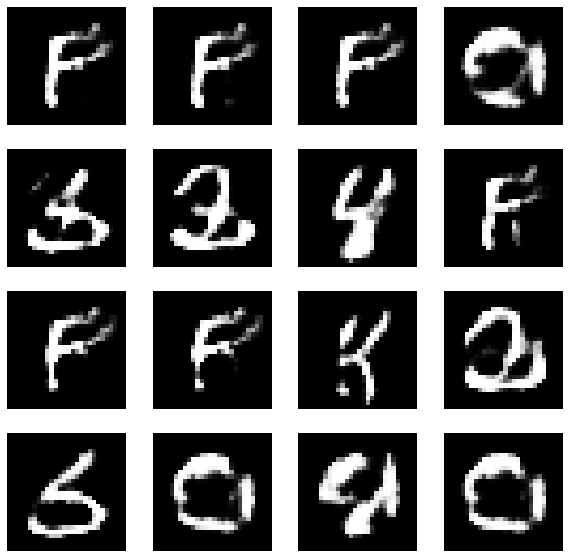

35000: [discriminator loss: 0.6693875789642334, acc: 0.296875] [gan loss: 1.853458, acc: 0.140625]
35001: [discriminator loss: 0.510991632938385, acc: 0.5] [gan loss: 0.396420, acc: 0.843750]
35002: [discriminator loss: 0.6839789152145386, acc: 0.234375] [gan loss: 1.566113, acc: 0.171875]
35003: [discriminator loss: 0.45616668462753296, acc: 0.5] [gan loss: 0.351813, acc: 0.859375]
35004: [discriminator loss: 0.48331576585769653, acc: 0.4140625] [gan loss: 0.653328, acc: 0.687500]
35005: [discriminator loss: 0.4533023238182068, acc: 0.5] [gan loss: 0.495198, acc: 0.796875]
35006: [discriminator loss: 0.4168225824832916, acc: 0.453125] [gan loss: 0.763201, acc: 0.562500]
35007: [discriminator loss: 0.41540202498435974, acc: 0.5] [gan loss: 0.312462, acc: 0.921875]
35008: [discriminator loss: 0.46700283885002136, acc: 0.421875] [gan loss: 1.084427, acc: 0.328125]
35009: [discriminator loss: 0.3452962040901184, acc: 0.5] [gan loss: 0.246687, acc: 0.937500]
35010: [discriminator loss: 0.6

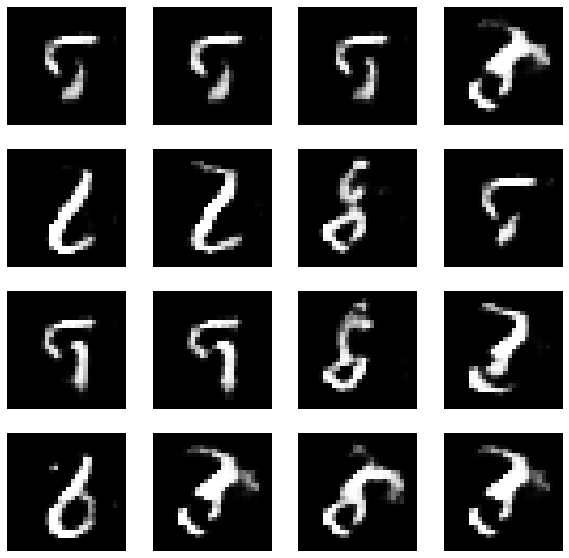

35500: [discriminator loss: 0.46246784925460815, acc: 0.5] [gan loss: 0.620132, acc: 0.656250]
35501: [discriminator loss: 0.5323836207389832, acc: 0.3203125] [gan loss: 1.518626, acc: 0.031250]
35502: [discriminator loss: 0.5136764049530029, acc: 0.5] [gan loss: 0.525345, acc: 0.750000]
35503: [discriminator loss: 0.6171656847000122, acc: 0.2109375] [gan loss: 1.753223, acc: 0.000000]
35504: [discriminator loss: 0.4643417000770569, acc: 0.5] [gan loss: 0.740493, acc: 0.609375]
35505: [discriminator loss: 0.531346321105957, acc: 0.3125] [gan loss: 1.976121, acc: 0.015625]
35506: [discriminator loss: 0.5156527161598206, acc: 0.484375] [gan loss: 0.918411, acc: 0.343750]
35507: [discriminator loss: 0.5269643068313599, acc: 0.359375] [gan loss: 1.793752, acc: 0.000000]
35508: [discriminator loss: 0.5772838592529297, acc: 0.4765625] [gan loss: 0.853770, acc: 0.312500]
35509: [discriminator loss: 0.5735472440719604, acc: 0.265625] [gan loss: 2.528347, acc: 0.000000]
35510: [discriminator lo

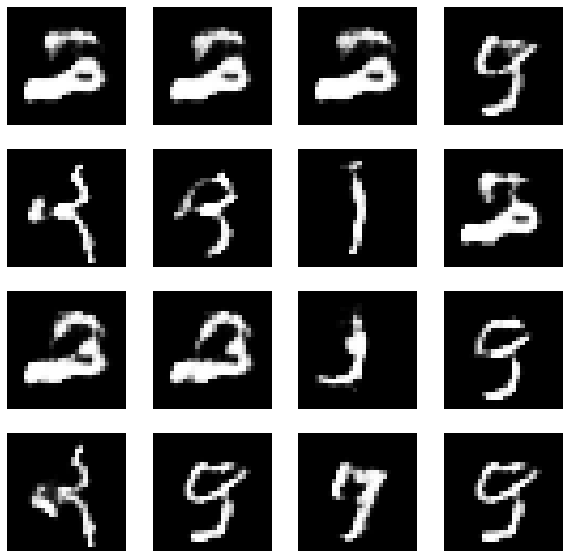

36000: [discriminator loss: 0.5122812986373901, acc: 0.5] [gan loss: 0.974680, acc: 0.203125]
36001: [discriminator loss: 0.6564381718635559, acc: 0.2109375] [gan loss: 2.632948, acc: 0.000000]
36002: [discriminator loss: 0.6246742010116577, acc: 0.5] [gan loss: 0.814100, acc: 0.406250]
36003: [discriminator loss: 0.6614528894424438, acc: 0.1796875] [gan loss: 2.419050, acc: 0.015625]
36004: [discriminator loss: 0.6076356172561646, acc: 0.4921875] [gan loss: 0.997866, acc: 0.328125]
36005: [discriminator loss: 0.5493535995483398, acc: 0.3671875] [gan loss: 1.756125, acc: 0.015625]
36006: [discriminator loss: 0.5172717571258545, acc: 0.4609375] [gan loss: 1.419284, acc: 0.046875]
36007: [discriminator loss: 0.5384638905525208, acc: 0.4453125] [gan loss: 1.494161, acc: 0.046875]
36008: [discriminator loss: 0.5611478686332703, acc: 0.3984375] [gan loss: 1.664309, acc: 0.000000]
36009: [discriminator loss: 0.5507504940032959, acc: 0.484375] [gan loss: 0.655737, acc: 0.687500]
36010: [discr

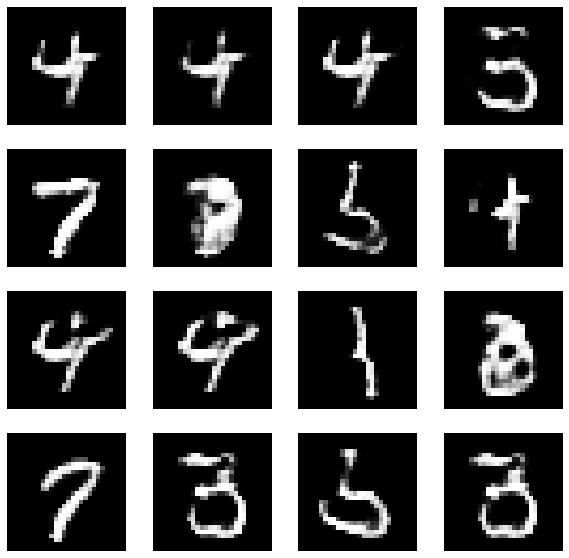

36500: [discriminator loss: 0.5658817291259766, acc: 0.2734375] [gan loss: 1.096218, acc: 0.546875]
36501: [discriminator loss: 0.5572051405906677, acc: 0.5] [gan loss: 0.123811, acc: 1.000000]
36502: [discriminator loss: 0.5726615786552429, acc: 0.2734375] [gan loss: 0.757064, acc: 0.531250]
36503: [discriminator loss: 0.561875581741333, acc: 0.5] [gan loss: 0.084178, acc: 1.000000]
36504: [discriminator loss: 0.5191553235054016, acc: 0.3359375] [gan loss: 0.653438, acc: 0.609375]
36505: [discriminator loss: 0.5705837607383728, acc: 0.5] [gan loss: 0.051003, acc: 1.000000]
36506: [discriminator loss: 0.6445679068565369, acc: 0.234375] [gan loss: 0.881245, acc: 0.453125]
36507: [discriminator loss: 0.5330313444137573, acc: 0.4921875] [gan loss: 0.202768, acc: 0.968750]
36508: [discriminator loss: 0.5094666481018066, acc: 0.390625] [gan loss: 0.773304, acc: 0.500000]
36509: [discriminator loss: 0.3891616761684418, acc: 0.5] [gan loss: 0.096131, acc: 1.000000]
36510: [discriminator loss:

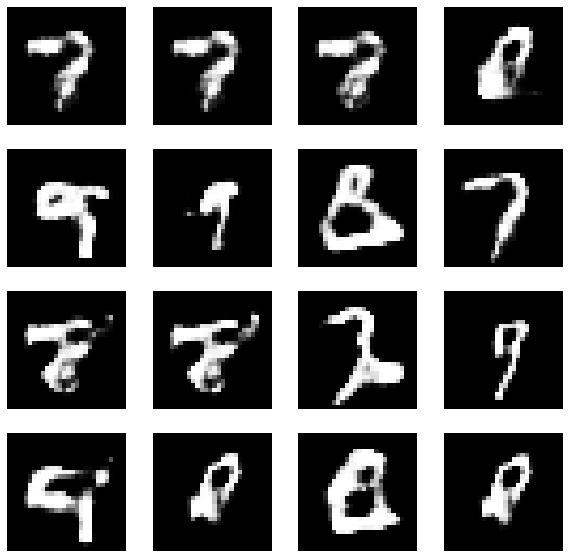

37000: [discriminator loss: 0.6948901414871216, acc: 0.421875] [gan loss: 0.680375, acc: 0.578125]
37001: [discriminator loss: 0.5259894132614136, acc: 0.390625] [gan loss: 0.874347, acc: 0.421875]
37002: [discriminator loss: 0.5734763145446777, acc: 0.3125] [gan loss: 1.281517, acc: 0.140625]
37003: [discriminator loss: 0.7171697020530701, acc: 0.3359375] [gan loss: 1.175079, acc: 0.171875]
37004: [discriminator loss: 0.48909473419189453, acc: 0.453125] [gan loss: 0.652848, acc: 0.578125]
37005: [discriminator loss: 0.5819275975227356, acc: 0.328125] [gan loss: 1.194331, acc: 0.187500]
37006: [discriminator loss: 0.5352871417999268, acc: 0.40625] [gan loss: 1.004277, acc: 0.234375]
37007: [discriminator loss: 0.7381086349487305, acc: 0.25] [gan loss: 2.441905, acc: 0.000000]
37008: [discriminator loss: 0.6435052752494812, acc: 0.484375] [gan loss: 0.691932, acc: 0.593750]
37009: [discriminator loss: 0.9235621690750122, acc: 0.0546875] [gan loss: 3.263268, acc: 0.000000]
37010: [discri

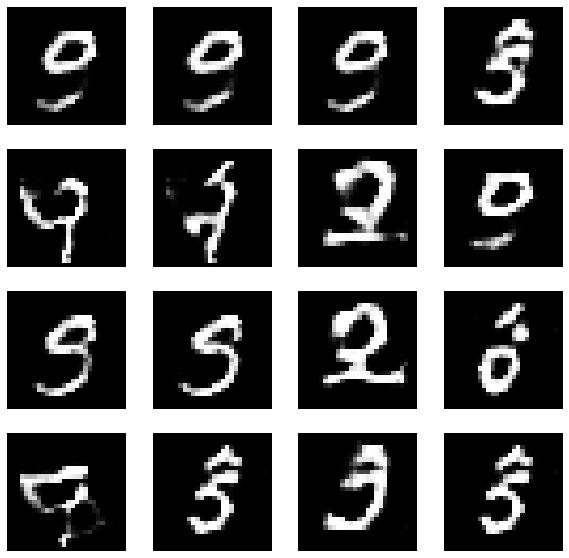

37500: [discriminator loss: 0.398499071598053, acc: 0.5] [gan loss: 0.808954, acc: 0.406250]
37501: [discriminator loss: 0.4360291361808777, acc: 0.4453125] [gan loss: 1.448618, acc: 0.031250]
37502: [discriminator loss: 0.49651336669921875, acc: 0.5] [gan loss: 0.304979, acc: 0.953125]
37503: [discriminator loss: 0.6074808835983276, acc: 0.2421875] [gan loss: 1.745983, acc: 0.000000]
37504: [discriminator loss: 0.5597870945930481, acc: 0.5] [gan loss: 0.551129, acc: 0.703125]
37505: [discriminator loss: 0.48273834586143494, acc: 0.4140625] [gan loss: 1.108628, acc: 0.203125]
37506: [discriminator loss: 0.4054233729839325, acc: 0.5] [gan loss: 0.689002, acc: 0.593750]
37507: [discriminator loss: 0.4333781599998474, acc: 0.46875] [gan loss: 1.043801, acc: 0.250000]
37508: [discriminator loss: 0.4347490668296814, acc: 0.5] [gan loss: 0.561872, acc: 0.765625]
37509: [discriminator loss: 0.5187380909919739, acc: 0.390625] [gan loss: 1.558047, acc: 0.000000]
37510: [discriminator loss: 0.55

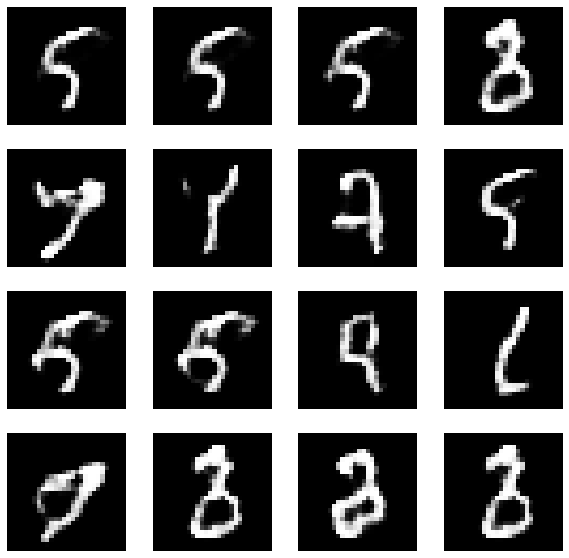

38000: [discriminator loss: 0.528724730014801, acc: 0.390625] [gan loss: 2.066785, acc: 0.000000]
38001: [discriminator loss: 0.5583728551864624, acc: 0.5] [gan loss: 0.647141, acc: 0.562500]
38002: [discriminator loss: 0.8021354079246521, acc: 0.09375] [gan loss: 3.005139, acc: 0.000000]
38003: [discriminator loss: 0.7077383995056152, acc: 0.5] [gan loss: 0.563154, acc: 0.687500]
38004: [discriminator loss: 0.8469430208206177, acc: 0.1171875] [gan loss: 2.029598, acc: 0.000000]
38005: [discriminator loss: 0.6056594848632812, acc: 0.4921875] [gan loss: 0.687002, acc: 0.578125]
38006: [discriminator loss: 0.6842255592346191, acc: 0.265625] [gan loss: 1.591027, acc: 0.031250]
38007: [discriminator loss: 0.5076832175254822, acc: 0.453125] [gan loss: 0.583843, acc: 0.640625]
38008: [discriminator loss: 0.6679967045783997, acc: 0.2265625] [gan loss: 1.019913, acc: 0.187500]
38009: [discriminator loss: 0.6513967514038086, acc: 0.4921875] [gan loss: 0.166324, acc: 1.000000]
38010: [discrimina

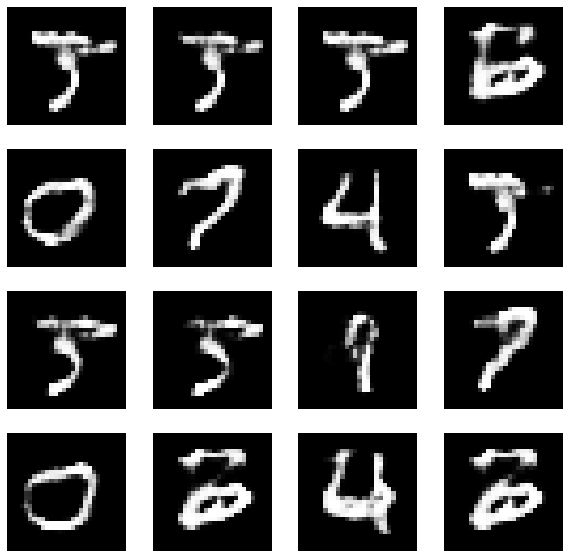

38500: [discriminator loss: 0.6964890360832214, acc: 0.5] [gan loss: 0.496856, acc: 0.765625]
38501: [discriminator loss: 0.8865264654159546, acc: 0.046875] [gan loss: 2.156995, acc: 0.000000]
38502: [discriminator loss: 0.7000288367271423, acc: 0.4921875] [gan loss: 0.530497, acc: 0.750000]
38503: [discriminator loss: 0.8171494007110596, acc: 0.0625] [gan loss: 2.154560, acc: 0.000000]
38504: [discriminator loss: 0.621093213558197, acc: 0.484375] [gan loss: 0.557141, acc: 0.687500]
38505: [discriminator loss: 0.7000515460968018, acc: 0.21875] [gan loss: 1.261142, acc: 0.062500]
38506: [discriminator loss: 0.6323730945587158, acc: 0.4765625] [gan loss: 0.407045, acc: 0.859375]
38507: [discriminator loss: 0.6994752883911133, acc: 0.1796875] [gan loss: 1.491716, acc: 0.031250]
38508: [discriminator loss: 0.6741538643836975, acc: 0.484375] [gan loss: 0.560657, acc: 0.765625]
38509: [discriminator loss: 0.6500651836395264, acc: 0.3203125] [gan loss: 1.381534, acc: 0.109375]
38510: [discrim

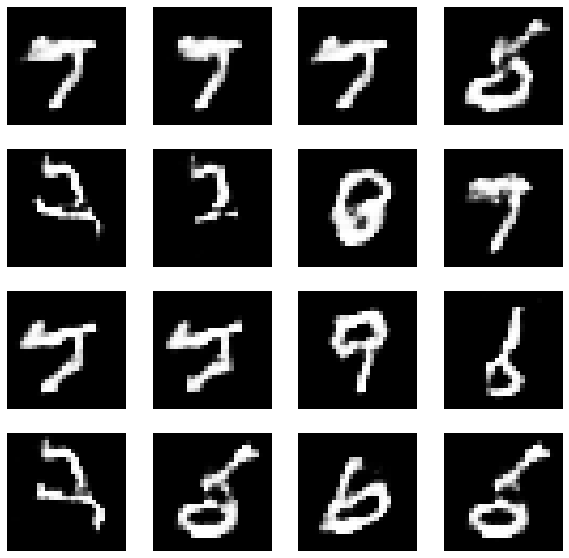

39000: [discriminator loss: 0.6111516356468201, acc: 0.5] [gan loss: 0.779667, acc: 0.406250]
39001: [discriminator loss: 0.6212674379348755, acc: 0.21875] [gan loss: 1.773144, acc: 0.031250]
39002: [discriminator loss: 0.5891081094741821, acc: 0.5] [gan loss: 0.732653, acc: 0.546875]
39003: [discriminator loss: 0.6443029642105103, acc: 0.1640625] [gan loss: 1.931903, acc: 0.031250]
39004: [discriminator loss: 0.6096846461296082, acc: 0.5] [gan loss: 0.751724, acc: 0.500000]
39005: [discriminator loss: 0.6532291173934937, acc: 0.15625] [gan loss: 1.889538, acc: 0.000000]
39006: [discriminator loss: 0.5718600749969482, acc: 0.5] [gan loss: 0.877276, acc: 0.281250]
39007: [discriminator loss: 0.5735759735107422, acc: 0.296875] [gan loss: 1.776455, acc: 0.000000]
39008: [discriminator loss: 0.46660494804382324, acc: 0.5] [gan loss: 0.929836, acc: 0.359375]
39009: [discriminator loss: 0.5707496404647827, acc: 0.3359375] [gan loss: 1.585364, acc: 0.000000]
39010: [discriminator loss: 0.4944

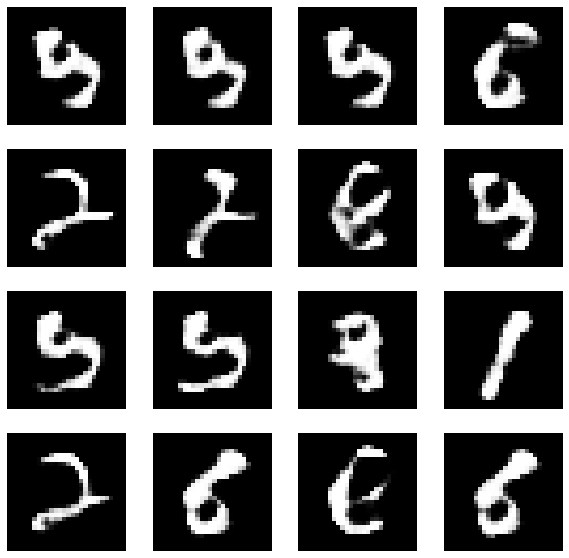

39500: [discriminator loss: 0.5015661716461182, acc: 0.359375] [gan loss: 0.372456, acc: 0.890625]
39501: [discriminator loss: 0.3660616874694824, acc: 0.5] [gan loss: 0.004131, acc: 1.000000]
39502: [discriminator loss: 0.3064442574977875, acc: 0.484375] [gan loss: 0.020270, acc: 1.000000]
39503: [discriminator loss: 0.3435487449169159, acc: 0.5] [gan loss: 0.005626, acc: 1.000000]
39504: [discriminator loss: 0.3129419982433319, acc: 0.4921875] [gan loss: 0.028985, acc: 1.000000]
39505: [discriminator loss: 0.3072265684604645, acc: 0.5] [gan loss: 0.014079, acc: 1.000000]
39506: [discriminator loss: 0.31450003385543823, acc: 0.4921875] [gan loss: 0.053996, acc: 1.000000]
39507: [discriminator loss: 0.2943493723869324, acc: 0.5] [gan loss: 0.005467, acc: 1.000000]
39508: [discriminator loss: 0.3289220631122589, acc: 0.4765625] [gan loss: 0.108256, acc: 1.000000]
39509: [discriminator loss: 0.36450424790382385, acc: 0.5] [gan loss: 0.010392, acc: 1.000000]
39510: [discriminator loss: 0.

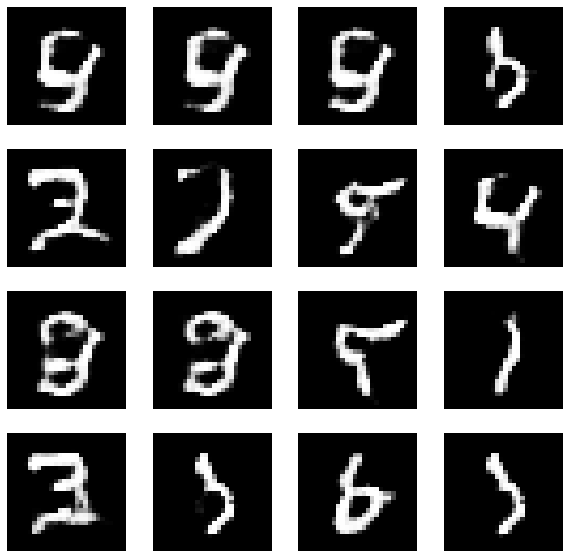

In [21]:
train(models=[gen, disc, gan], x_train=x_train)

In [22]:
for layer in gen.layers:
    try:
        print(layer.name)
        weights = layer.get_weights()[0]
        print(weights.mean(), weights.std(), weights.shape)
    except:
        pass

dense
0.00017838039 0.020661391 (2, 6272)
reshape
conv_trans_block
1.0032827 0.009660529 (128,)
conv_trans_block_1
1.0063775 0.012679504 (128,)
conv_trans_block_2
0.99216145 0.03157997 (64,)
conv_trans_block_3
1.2189934 0.087466225 (32,)
activation_4


In [23]:
gen.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  18816     
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv_trans_block (ConvTransB multiple                  410240    
_________________________________________________________________
conv_trans_block_1 (ConvTran multiple                  205376    
_________________________________________________________________
conv_trans_block_2 (ConvTran multiple                  51488     
_________________________________________________________________
conv_trans_block_3 (ConvTran multiple                  929       
_________________________________________________________________
activation_4 (Activation)    multiple                  0 

In [24]:
imgs_in_row = 20
l1 = np.linspace(-1, 1, imgs_in_row)
l2 = np.linspace(-1, 1, imgs_in_row)
noise = np.array([l1, l2]).T


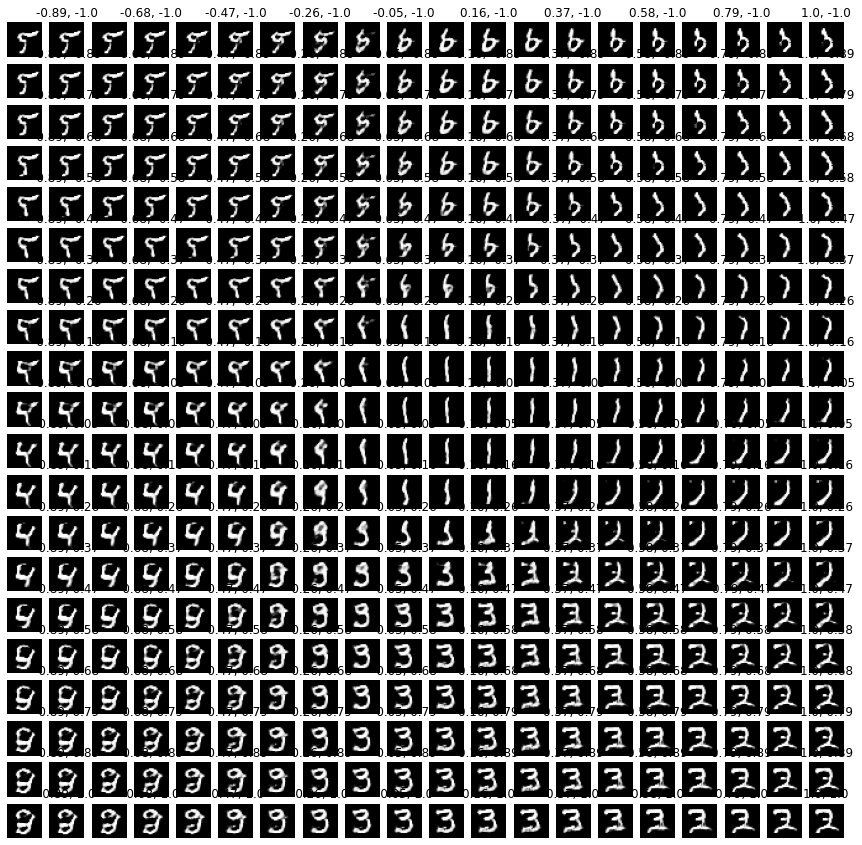

In [25]:
i = 0
plt.figure(figsize=(15, 15))
for n in range(imgs_in_row):
    for m in range(imgs_in_row):
        i += 1
        plt.subplot(imgs_in_row, imgs_in_row, i)
        image = gen.predict(np.array([l1[m], l2[n]]).reshape(-1, 2)).reshape(28, 28)
        # image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        if i % 2 == 0:
            plt.title(f"{round(l1[m], 2)}, {round(l2[n], 2)}")
        plt.axis('off')



In [26]:
l1, l2


(array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]))

ValueError: ignored

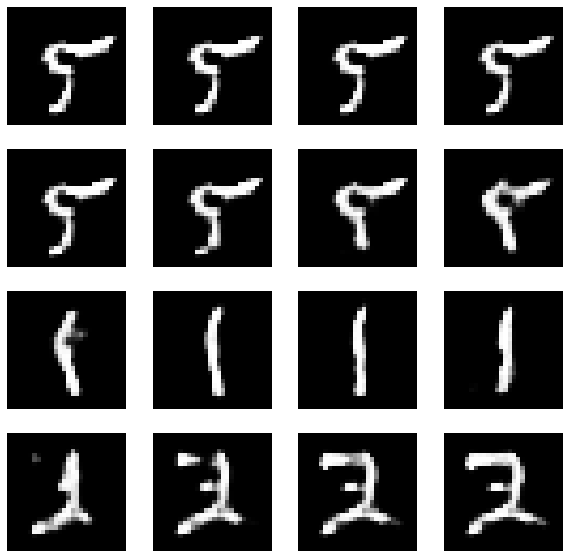

In [27]:
plot_images(gen, noise)

In [ ]:
np.array([l1[m], l2[n]]).reshape(-1, 2).shape